# BBC Dataset Exploratory Data Analysis

In [ ]:
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD, PCA
from nltk import pos_tag, word_tokenize
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
from sklearn.manifold import TSNE
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.util import ngrams
import seaborn as sns
import pandas as pd
import numpy as np
import nltk


plt.style.use('dark_background')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\andras.janko\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [2]:
bbc_df = pd.read_csv("_data/bbc_dataset_preprocessed.csv")
bbc_df


file_name  category                                               text  \
0      001.txt  business  Ad sales boost Time Warner profit\n\nQuarterly...   
1      002.txt  business  Dollar gains on Greenspan speech\n\nThe dollar...   
2      003.txt  business  Yukos unit buyer faces loan claim\n\nThe owner...   
3      004.txt  business  High fuel prices hit BA's profits\n\nBritish A...   
4      005.txt  business  Pernod takeover talk lifts Domecq\n\nShares in...   
...        ...       ...                                                ...   
2220   397.txt      tech  BT program to beat dialler scams\n\nBT is intr...   
2221   398.txt      tech  Spam e-mails tempt net shoppers\n\nComputer us...   
2222   399.txt      tech  Be careful how you code\n\nA new European dire...   
2223   400.txt      tech  US cyber security chief resigns\n\nThe man mak...   
2224   401.txt      tech  Losing yourself in online gaming\n\nOnline rol...   

                                           cleaned_text  \
0     ad sales boost time warner profit quarterly pr...   
1     dollar gains on greenspan speech the dollar ha...   
2     yukos unit buyer faces loan claim the owners o...   
3     high fuel prices hit ba s profits british airw...   
4     pernod takeover talk lifts domecq shares in uk...   
...                                                 ...   
2220  bt program to beat dialler scams bt is introdu...   
2221  spam e mails tempt net shoppers computer users...   
2222  be careful how you code a new european directi...   
2223  us cyber security chief resigns the man making...   
2224  losing yourself in online gaming online role p...   

                                        normalized_text  
0     ad sale boost time warner profit quarterly pro...  
1     dollar gain greenspan speech dollar hit highes...  
2     yukos unit buyer face loan claim owner embattl...  
3     high fuel price hit ba profit british airway b...  
4     pernod takeover talk lift domecq share uk drin...  
...                                                 ...  
2220  bt program beat dialler scam bt introducing tw...  
2221  spam e mail tempt net shopper computer user ac...  
2222  careful code new european directive could put ...  
2223  u cyber security chief resigns man making sure...  
2224  losing online gaming online role playing game ...  

[2225 rows x 5 columns]

## 1. Vocabulary analysis

##### 1.1 WORD FREQUENCY


Category: business
  Document count: 510
  Total words: 98616
  Unique words: 9750
  Top 10 words:
    said: 1680
    year: 960
    u: 830
    bn: 785
    company: 628
    mr: 603
    firm: 555
    market: 529
    would: 464
    also: 440

Category: entertainment
  Document count: 386
  Total words: 73931
  Unique words: 10037
  Top 10 words:
    film: 976
    said: 825
    year: 684
    best: 619
    award: 517
    music: 435
    u: 414
    show: 406
    also: 398
    one: 385

Category: politics
  Document count: 417
  Total words: 105580
  Unique words: 9452
  Top 10 words:
    said: 2241
    mr: 1718
    would: 1054
    labour: 767
    government: 745
    party: 726
    election: 677
    people: 623
    blair: 579
    minister: 569

Category: sport
  Document count: 511
  Total words: 93085
  Unique words: 9263
  Top 10 words:
    said: 942
    year: 671
    game: 654
    first: 484
    time: 483
    player: 479
    win: 472
    england: 461
    back: 400
    would: 396

Category:

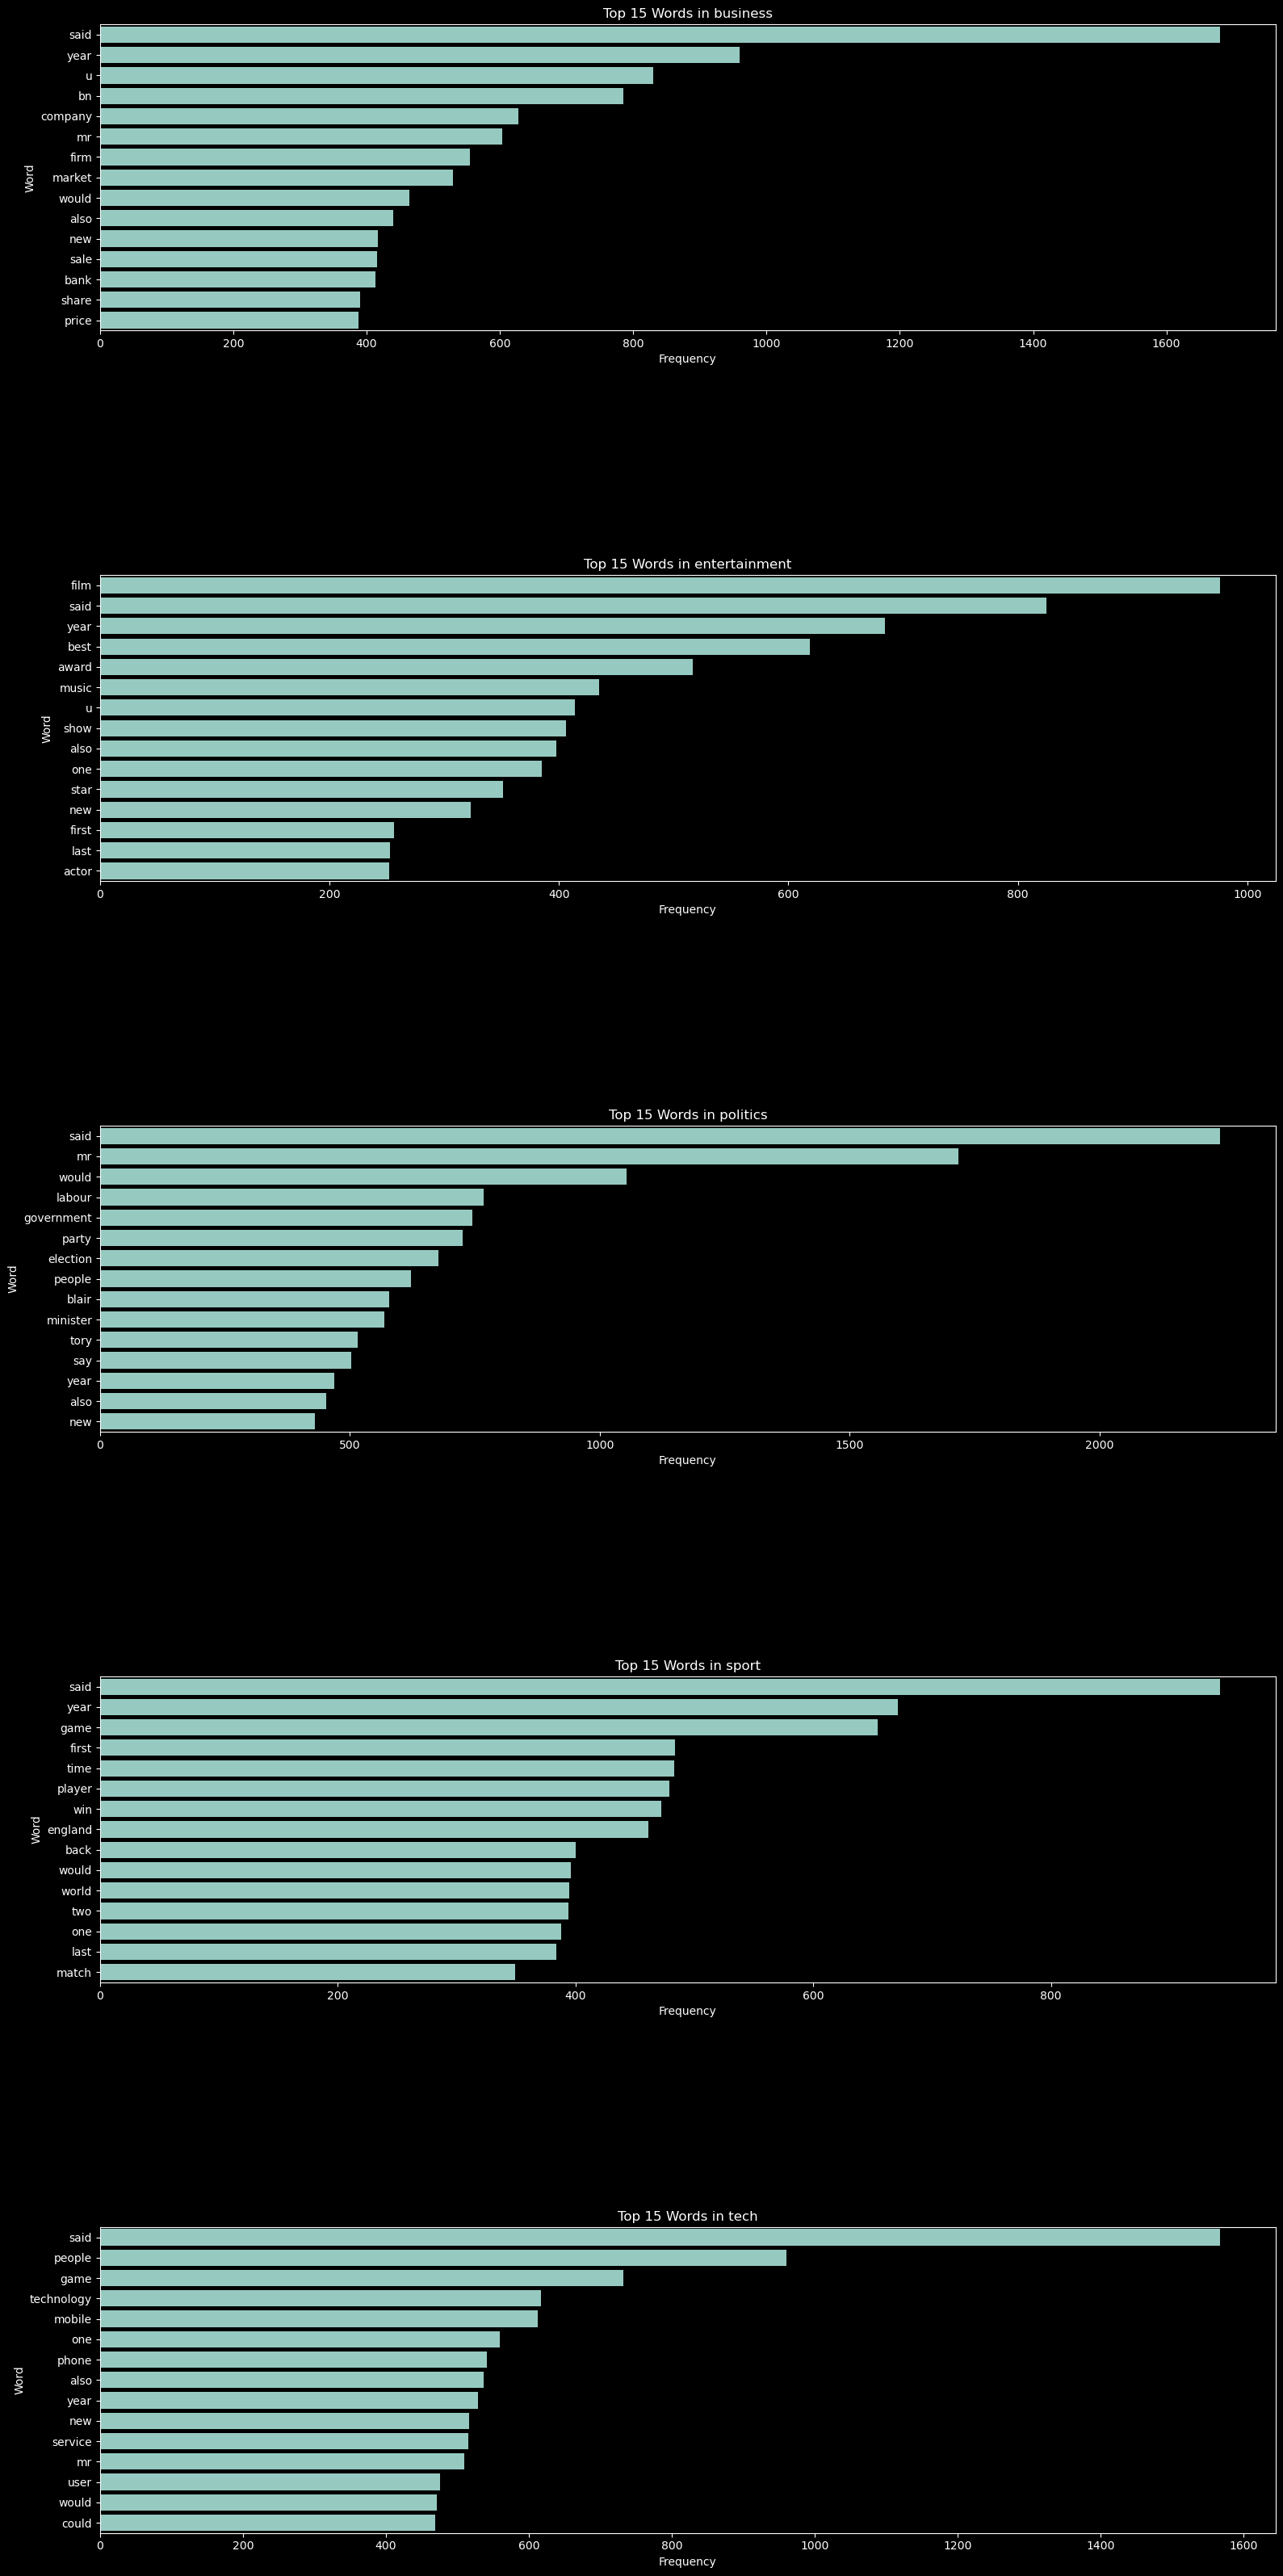

In [3]:
def get_tokens(text):
    return text.split()

# lets process the dataset by category
categories = bbc_df['category'].unique()
tokens_by_category = {}
word_sets_by_category = {}

for category in categories:
    # get all texts for this categoryí
    texts = bbc_df[bbc_df['category'] == category]['normalized_text'].tolist()

    # tokenize all texts in this category
    cat_tokens = []
    for text in texts:
        cat_tokens.extend(get_tokens(text))

    tokens_by_category[category] = cat_tokens
    word_sets_by_category[category] = set(cat_tokens)

    word_counts = Counter(cat_tokens)
    print(f"\nCategory: {category}")
    print(f"  Document count: {len(texts)}")
    print(f"  Total words: {len(cat_tokens)}")
    print(f"  Unique words: {len(word_counts)}")
    print("  Top 10 words:")
    for word, count in word_counts.most_common(10):
        print(f"    {word}: {count}")

plt.figure(figsize=(16, 32))
for i, category in enumerate(categories):
    plt.subplot(len(categories), 1, i+1)
    word_counts = Counter(tokens_by_category[category])
    top_words = pd.DataFrame(word_counts.most_common(15), columns=['Word', 'Frequency'])
    sns.barplot(x='Frequency', y='Word', data=top_words)
    plt.title(f'Top 15 Words in {category}')
    plt.tight_layout()

plt.subplots_adjust(hspace=0.8)
plt.show()

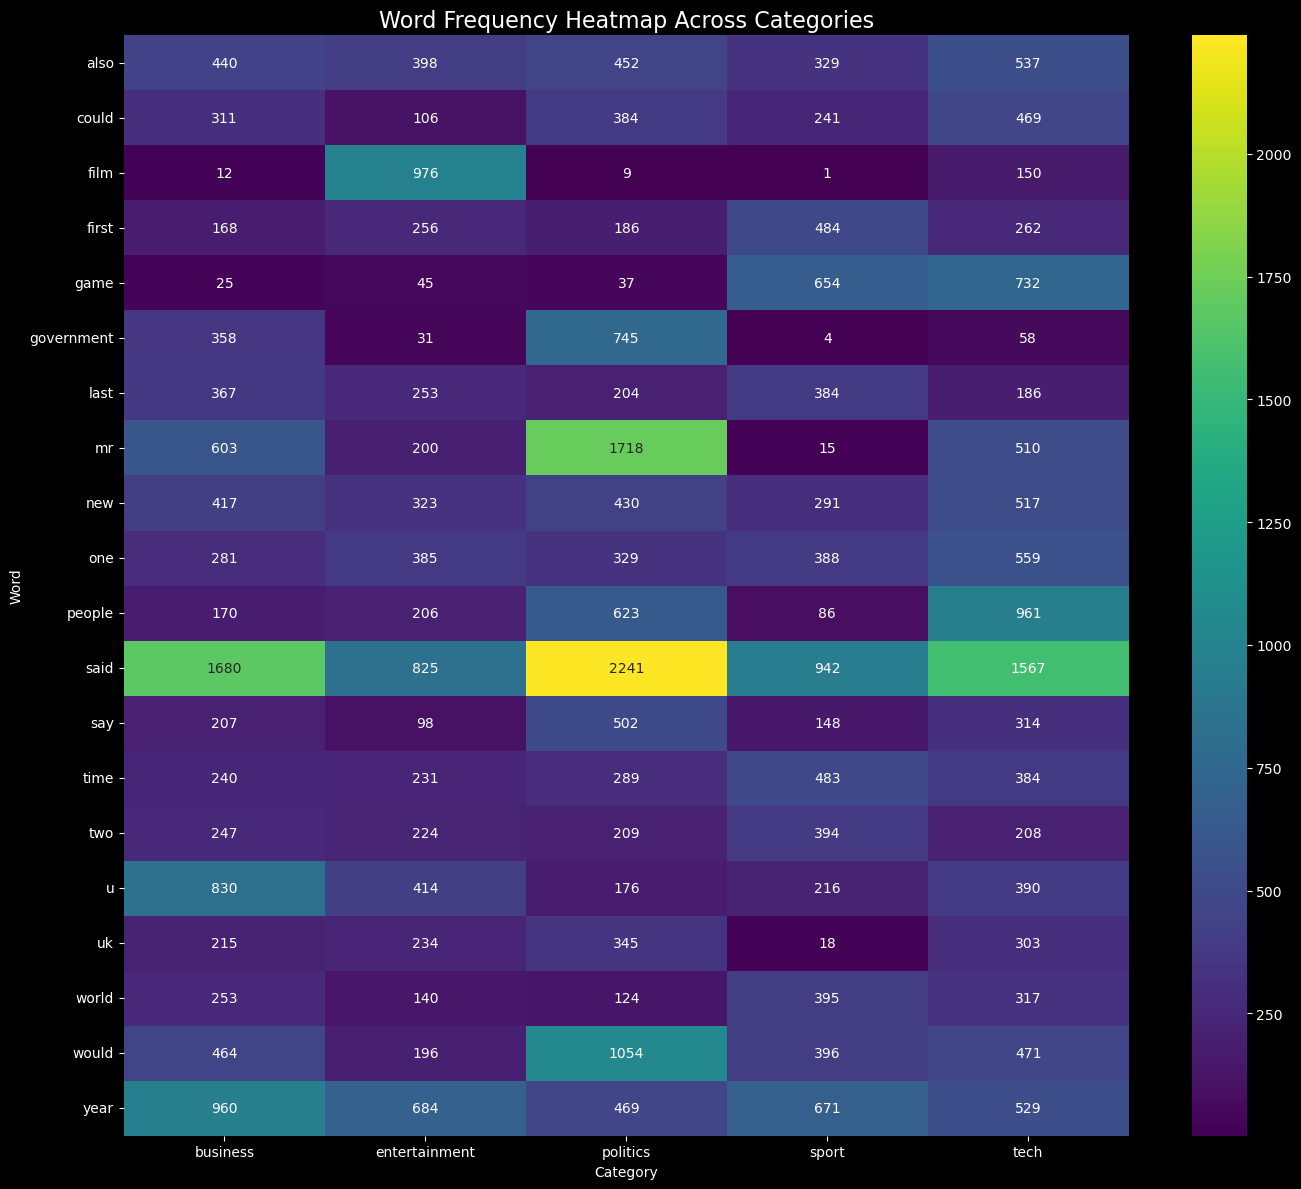

In [4]:
all_tokens = []
for cat in categories:
    all_tokens.extend(tokens_by_category[cat])

overall_counts = Counter(all_tokens)
top_overall_words = [word for word, _ in overall_counts.most_common(20)]

plot_data = []
for category in categories:
    cat_counts = Counter(tokens_by_category[category])
    for word in top_overall_words:
        plot_data.append({
            'Category': category,
            'Word': word,
            'Frequency': cat_counts.get(word, 0)
        })

plot_df = pd.DataFrame(plot_data)

pivot_df = plot_df.pivot(index='Word', columns='Category', values='Frequency')
plt.figure(figsize=(14, 12))
sns.heatmap(pivot_df, cmap='viridis', annot=True, fmt='d')
plt.title('Word Frequency Heatmap Across Categories', fontsize=16)
plt.tight_layout()
plt.show()

##### 1.2 CLASS-SPECIFIC VOCABULARY OVERLAP


Overlap between 'business' and 'entertainment':
  Shared words: 4523 words
  Jaccard similarity: 29.6%
  Examples of common words (with combined frequency):
    said: 2505
    year: 1644
    u: 1244
    film: 988
    also: 838

Overlap between 'business' and 'politics':
  Shared words: 5060 words
  Jaccard similarity: 35.8%
  Examples of common words (with combined frequency):
    said: 3921
    mr: 2321
    would: 1518
    year: 1429
    government: 1103

Overlap between 'business' and 'sport':
  Shared words: 4256 words
  Jaccard similarity: 28.8%
  Examples of common words (with combined frequency):
    said: 2622
    year: 1631
    u: 1046
    would: 860
    also: 769

Overlap between 'business' and 'tech':
  Shared words: 5000 words
  Jaccard similarity: 33.6%
  Examples of common words (with combined frequency):
    said: 3247
    year: 1489
    u: 1220
    people: 1131
    mr: 1113

Overlap between 'entertainment' and 'politics':
  Shared words: 4835 words
  Jaccard similarity:

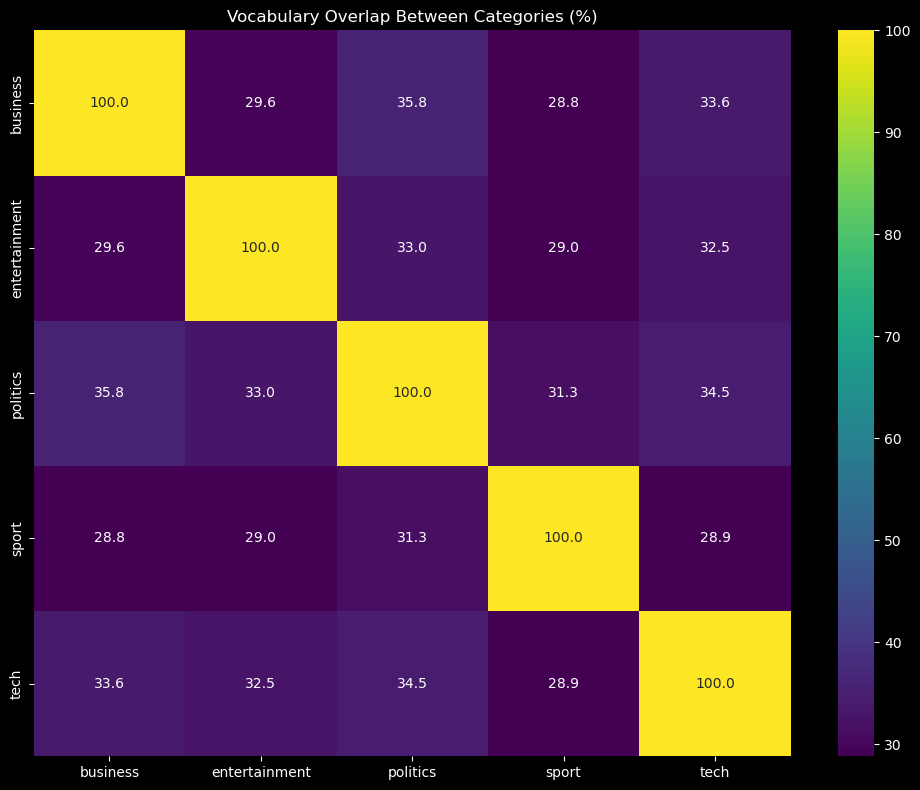

In [5]:
# matrix to display overlap percentages
overlap_matrix = pd.DataFrame(0.0, index=categories, columns=categories)

for cat1 in categories:
    for cat2 in categories:
        set1 = word_sets_by_category[cat1]
        set2 = word_sets_by_category[cat2]

        # calc the Jaccard similarity
        intersection = len(set1.intersection(set2))
        union = len(set1.union(set2))

        if union > 0:
            overlap_percent = float((intersection / union) * 100)
        else:
            overlap_percent = 0.0

        overlap_matrix.loc[cat1, cat2] = overlap_percent

        if cat1 < cat2:  # only print each pair once
            print(f"\nOverlap between '{cat1}' and '{cat2}':")
            print(f"  Shared words: {intersection} words")
            print(f"  Jaccard similarity: {overlap_percent:.1f}%")

            # examples of common words
            common_words = set1.intersection(set2)
            if common_words:
                # get frequencies in both categories
                cat1_counts = Counter(tokens_by_category[cat1])
                cat2_counts = Counter(tokens_by_category[cat2])

                # find words with highest combined frequency
                common_word_counts = [(w, cat1_counts[w] + cat2_counts[w]) for w in common_words]
                top_common = sorted(common_word_counts, key=lambda x: x[1], reverse=True)[:5]

                print("  Examples of common words (with combined frequency):")
                for word, freq in top_common:
                    print(f"    {word}: {freq}")

plt.figure(figsize=(10, 8))
sns.heatmap(overlap_matrix, annot=True, cmap='viridis', fmt='.1f')
plt.title('Vocabulary Overlap Between Categories (%)')
plt.tight_layout()
plt.show()

##### 1.3 UNIQUE WORD COUNTS PER CLASS


Category: business
  Total vocabulary: 9750 unique words
  Words unique to this category: 2827 (29.0%)
  Examples of words unique to this category (with frequency):
    yukos: 200
    gm: 82
    lse: 79
    gazprom: 74
    fiat: 72
    boerse: 67
    worldcom: 65
    ebbers: 63
    rosneft: 60
    yugansk: 59

Category: entertainment
  Total vocabulary: 10037 unique words
  Words unique to this category: 3181 (31.7%)
  Examples of words unique to this category (with frequency):
    actress: 163
    festival: 150
    aviator: 102
    foxx: 58
    rapper: 48
    drake: 47
    sideways: 45
    scorsese: 44
    swank: 42
    eastwood: 41

Category: politics
  Total vocabulary: 9452 unique words
  Words unique to this category: 2270 (24.0%)
  Examples of words unique to this category (with frequency):
    tory: 516
    lib: 180
    ukip: 129
    kilroy: 122
    blunkett: 106
    dems: 102
    asylum: 98
    prescott: 43
    detention: 38
    goldsmith: 37

Category: sport
  Total vocabular

<Figure size 1400x800 with 0 Axes>

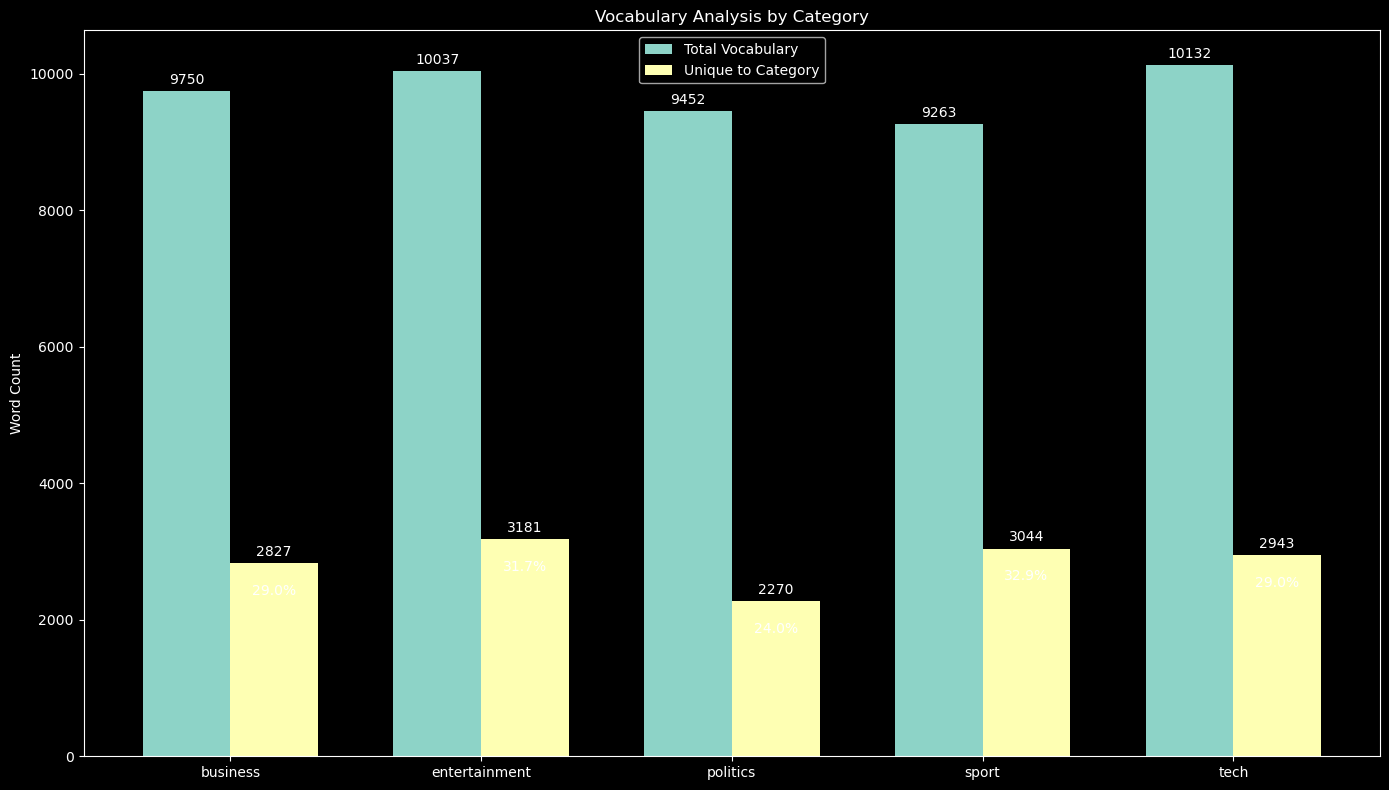

In [6]:
unique_words_by_category = {}

for category in categories:
    # get words from all other categories
    other_categories = [c for c in categories if c != category]
    other_words = set()
    for other_cat in other_categories:
        other_words.update(word_sets_by_category[other_cat])

    # words in this category but not in others
    unique_words = word_sets_by_category[category] - other_words
    unique_words_by_category[category] = unique_words

    print(f"\nCategory: {category}")
    print(f"  Total vocabulary: {len(word_sets_by_category[category])} unique words")
    print(f"  Words unique to this category: {len(unique_words)} ({len(unique_words)/len(word_sets_by_category[category])*100:.1f}%)")

    # top unique words by frequency
    if unique_words:
        cat_counts = Counter(tokens_by_category[category])
        unique_word_counts = [(w, cat_counts[w]) for w in unique_words]
        top_unique = sorted(unique_word_counts, key=lambda x: x[1], reverse=True)[:10]

        print("  Examples of words unique to this category (with frequency):")
        for word, count in top_unique:
            print(f"    {word}: {count}")

plt.figure(figsize=(14, 8))
total_vocab = [len(word_sets_by_category[cat]) for cat in categories]
unique_vocab = [len(unique_words_by_category[cat]) for cat in categories]

x = np.arange(len(categories))
width = 0.35

fig, ax = plt.subplots(figsize=(14, 8))
bars1 = ax.bar(x - width/2, total_vocab, width, label='Total Vocabulary')
bars2 = ax.bar(x + width/2, unique_vocab, width, label='Unique to Category')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.set_ylabel('Word Count')
ax.set_title('Vocabulary Analysis by Category')
ax.legend()

for i, bars in enumerate([bars1, bars2]):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# percentage labels for unique words
for i, v in enumerate(unique_vocab):
    percentage = (v / total_vocab[i]) * 100
    ax.annotate(f'{percentage:.1f}%',
                xy=(x[i] + width/2, v),
                xytext=(0, -15),
                textcoords="offset points",
                ha='center', va='top')

plt.tight_layout()
plt.show()

## 2. Text visualization

##### 2.1 WORD CLOUDS FOR EACH CLASS

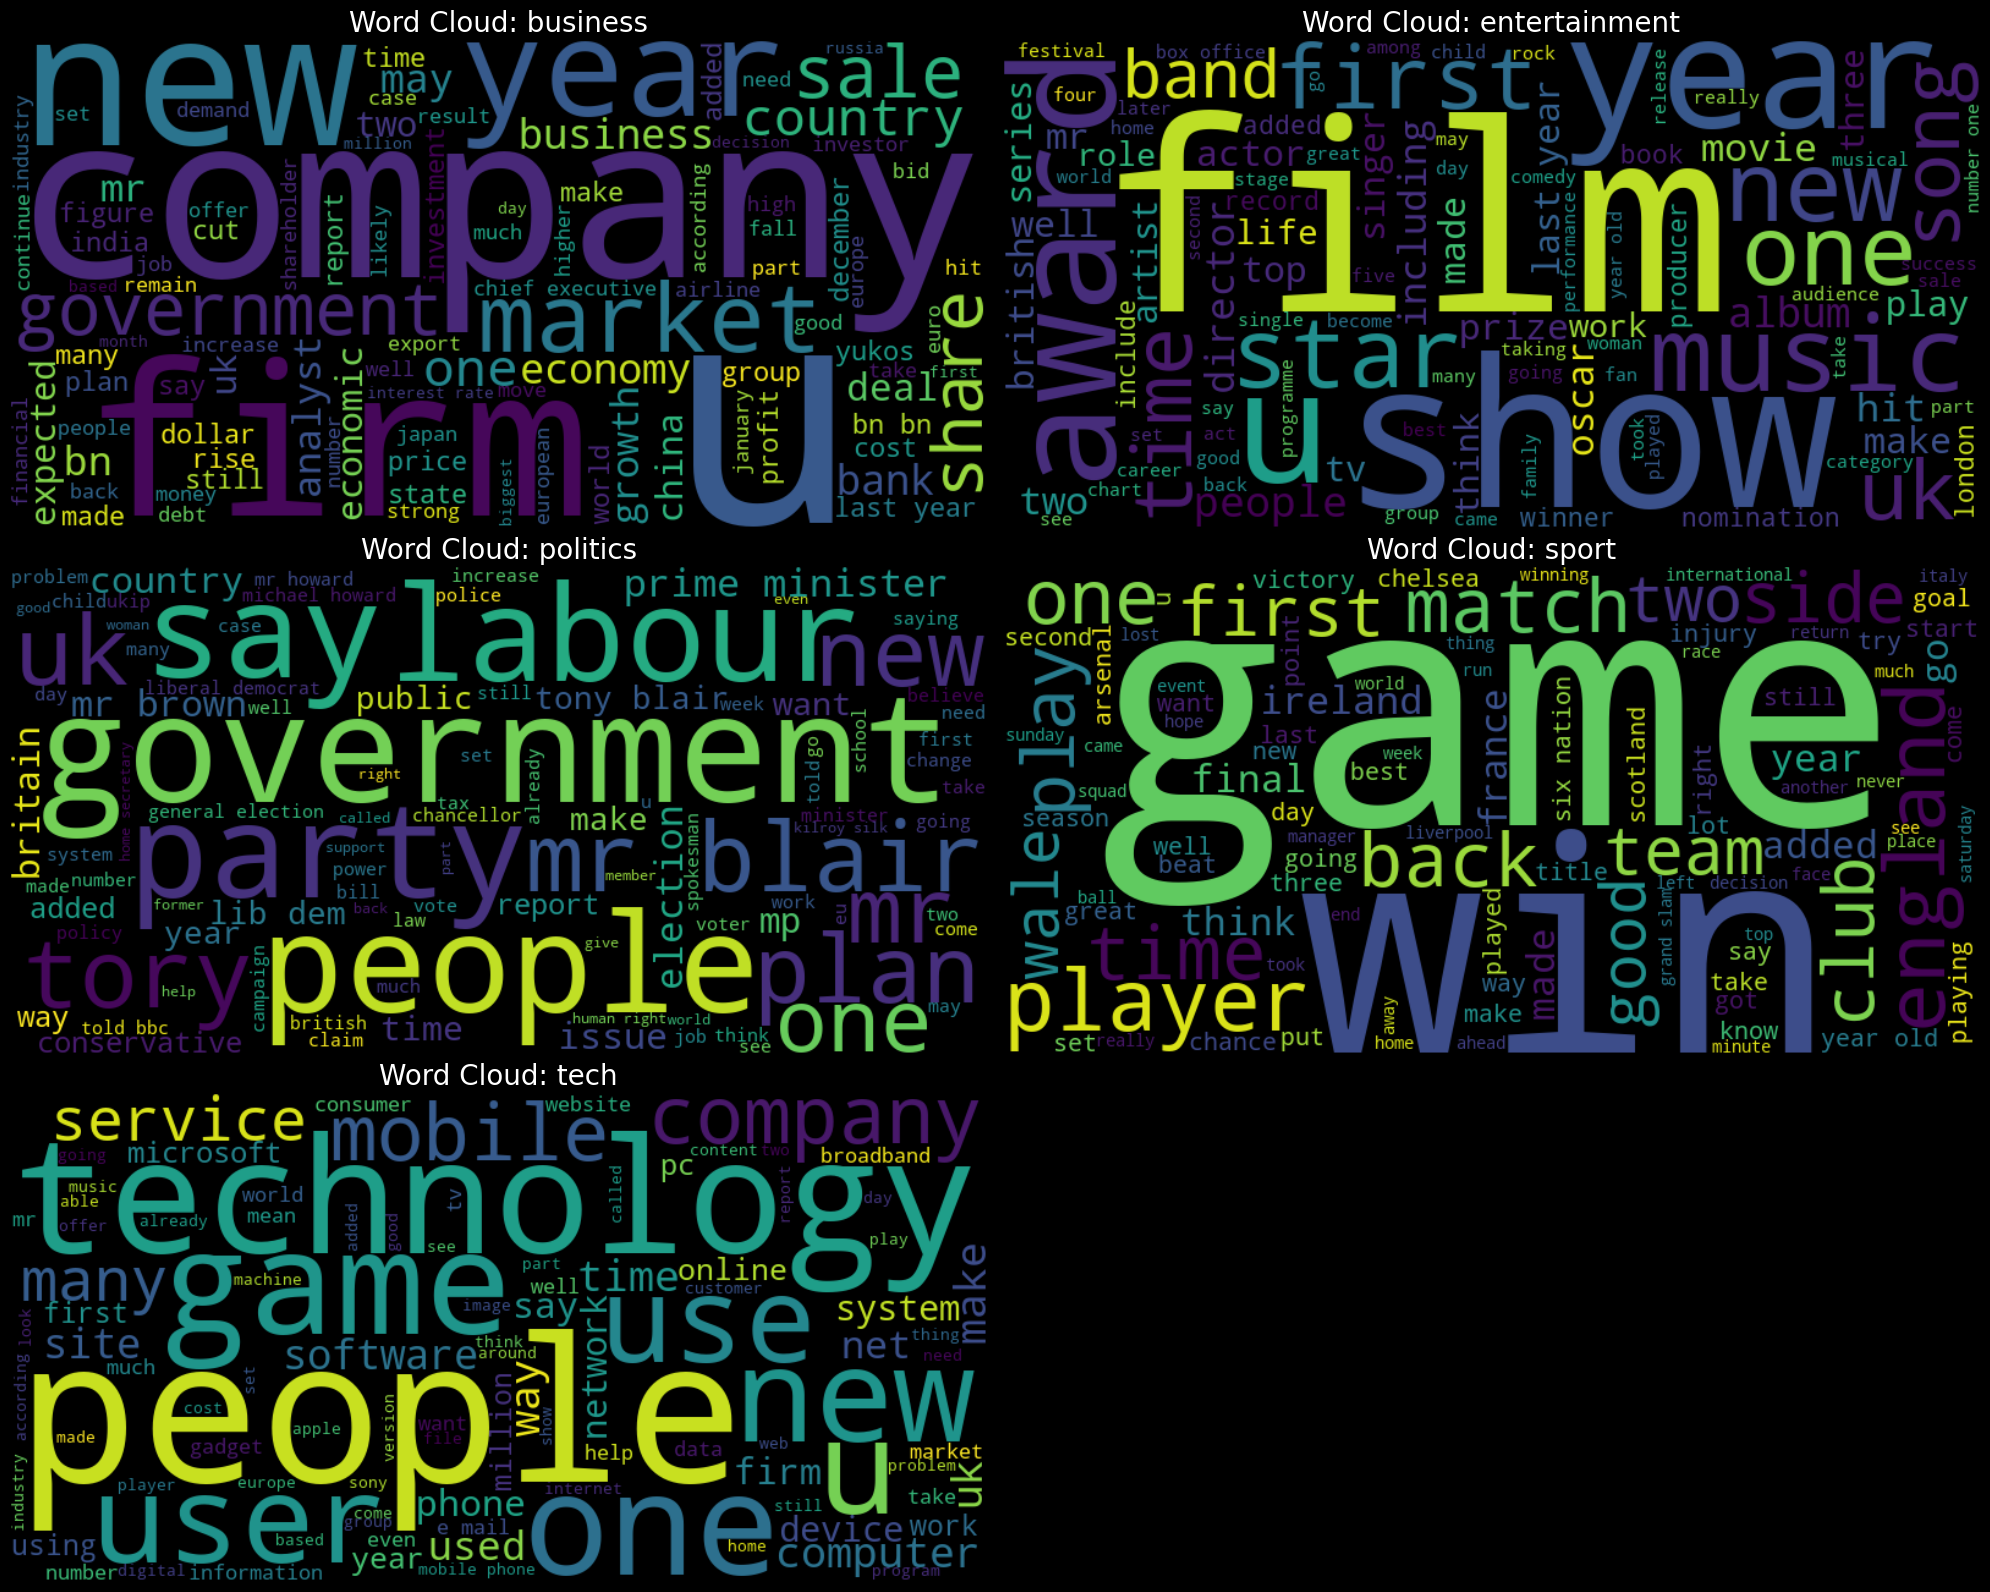

In [7]:
plt.figure(figsize=(20, 16))
gs = gridspec.GridSpec(3, 2, width_ratios=[1, 1], height_ratios=[1, 1, 1])

for i, category in enumerate(categories):
    category_text = ' '.join(bbc_df[bbc_df['category'] == category]['normalized_text'])

    filtered_words = [word for word in category_text.split() if word != "said"]
    filtered_text = ' '.join(filtered_words)

    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='black',
        colormap='viridis',
        max_words=100,
        contour_width=3,
        contour_color='steelblue'
    ).generate(filtered_text)

    row = i // 2
    col = i % 2

    ax = plt.subplot(gs[row, col])
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(f'Word Cloud: {category}', fontsize=20)
    ax.axis('off')

plt.tight_layout()
plt.show()

##### 2.2 N-GRAM FREQUENCY ANALYSIS


Bigrams Analysis

Category: business
  Total bigrams: 73,143
  Top 5 bigrams:
    1. 'last year': 181
    2. 'bn bn': 154
    3. 'chief executive': 132
    4. 'interest rate': 102
    5. 'stock market': 89

Category: entertainment
  Total bigrams: 55,525
  Top 5 bigrams:
    1. 'last year': 124
    2. 'box office': 91
    3. 'number one': 83
    4. 'year old': 78
    5. 'new york': 63

Category: politics
  Total bigrams: 72,236
  Top 5 bigrams:
    1. 'mr blair': 328
    2. 'prime minister': 281
    3. 'mr brown': 240
    4. 'tony blair': 179
    5. 'general election': 168

Category: sport
  Total bigrams: 67,747
  Top 5 bigrams:
    1. 'year old': 195
    2. 'six nation': 162
    3. 'grand slam': 95
    4. 'new zealand': 89
    5. 'world cup': 87

Category: tech
  Total bigrams: 74,748
  Top 5 bigrams:
    1. 'e mail': 192
    2. 'said mr': 190
    3. 'mobile phone': 163
    4. 'bbc news': 93
    5. 'told bbc': 86


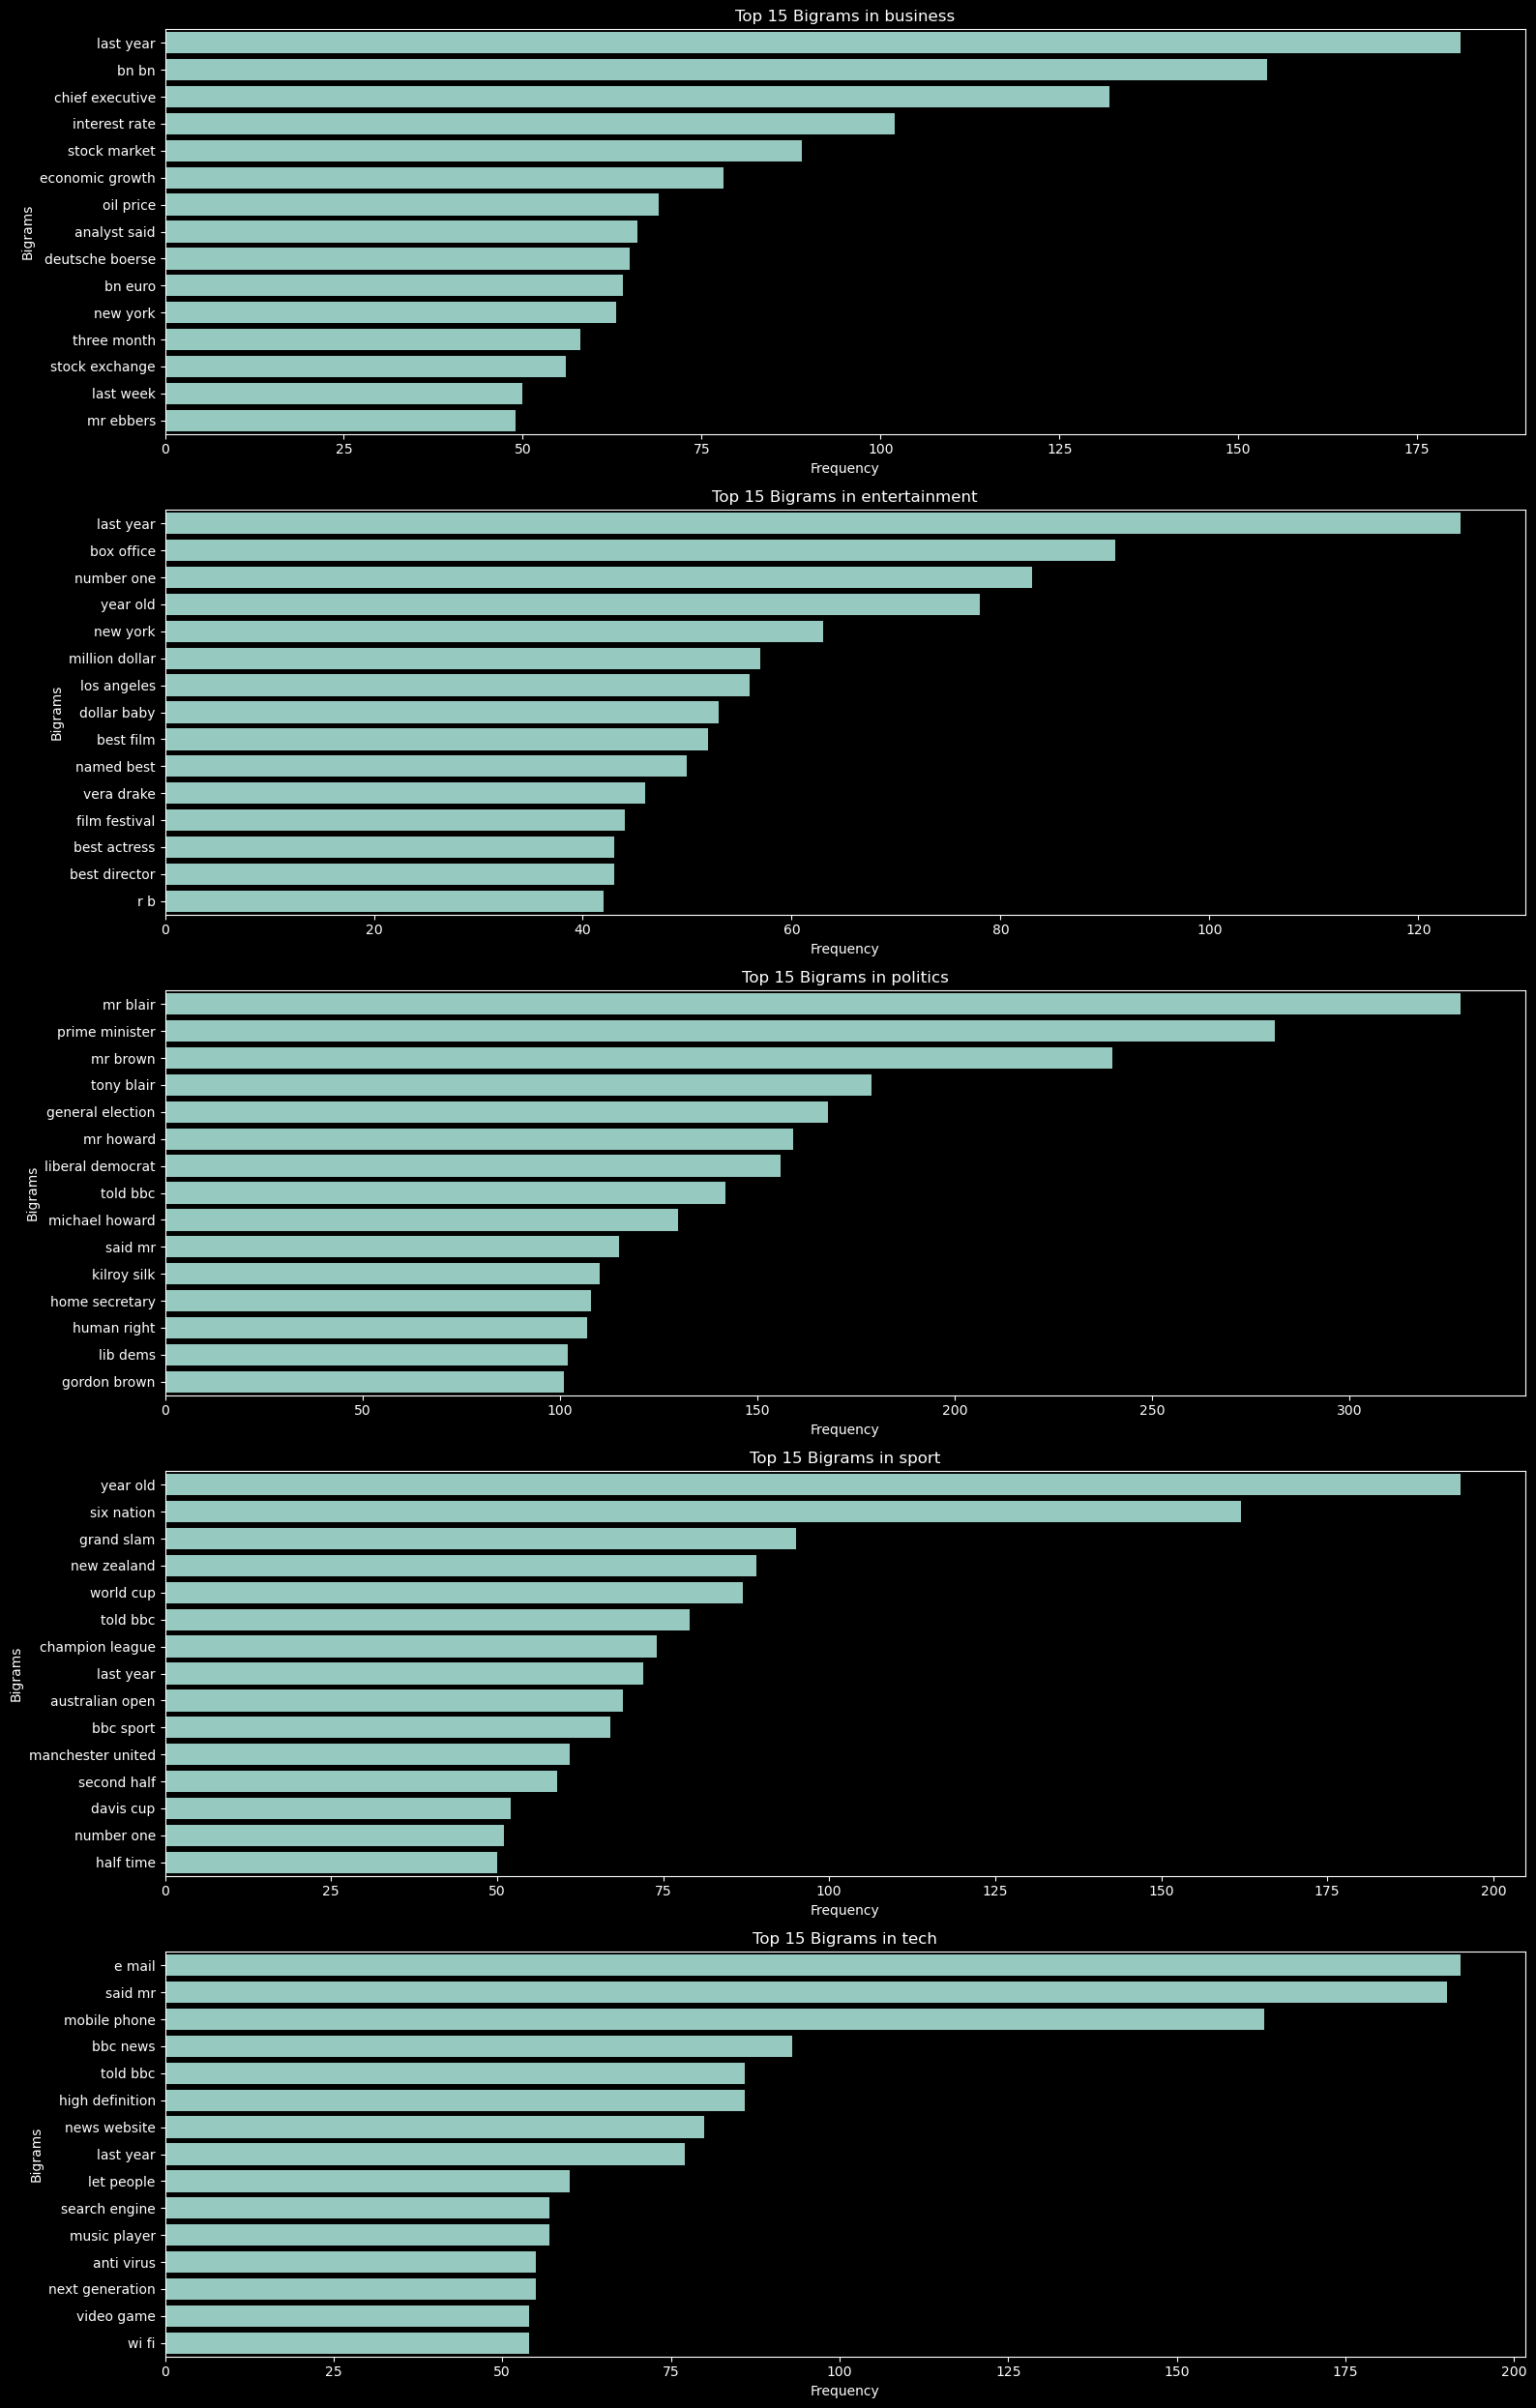


Trigrams Analysis

Category: business
  Total trigrams: 90,225
  Top 5 trigrams:
    1. 'london stock exchange': 22
    2. 'security exchange commission': 21
    3. 'bn euro bn': 21
    4. 'interest rate rise': 18
    5. 'reuters news agency': 17

Category: entertainment
  Total trigrams: 65,883
  Top 5 trigrams:
    1. 'million dollar baby': 53
    2. 'u box office': 20
    3. 'actor jamie foxx': 20
    4. 'best supporting actor': 17
    5. 'berlin film festival': 15

Category: politics
  Total trigrams: 90,155
  Top 5 trigrams:
    1. 'leader michael howard': 58
    2. 'told bbc radio': 57
    3. 'mr kilroy silk': 57
    4. 'mr blair said': 54
    5. 'radio today programme': 45

Category: sport
  Total trigrams: 82,944
  Top 5 trigrams:
    1. 'told bbc sport': 48
    2. 'coach andy robinson': 27
    3. 'world number one': 27
    4. 'sir alex ferguson': 21
    5. 'rb six nation': 21

Category: tech
  Total trigrams: 89,738
  Top 5 trigrams:
    1. 'bbc news website': 80
    2. 'told

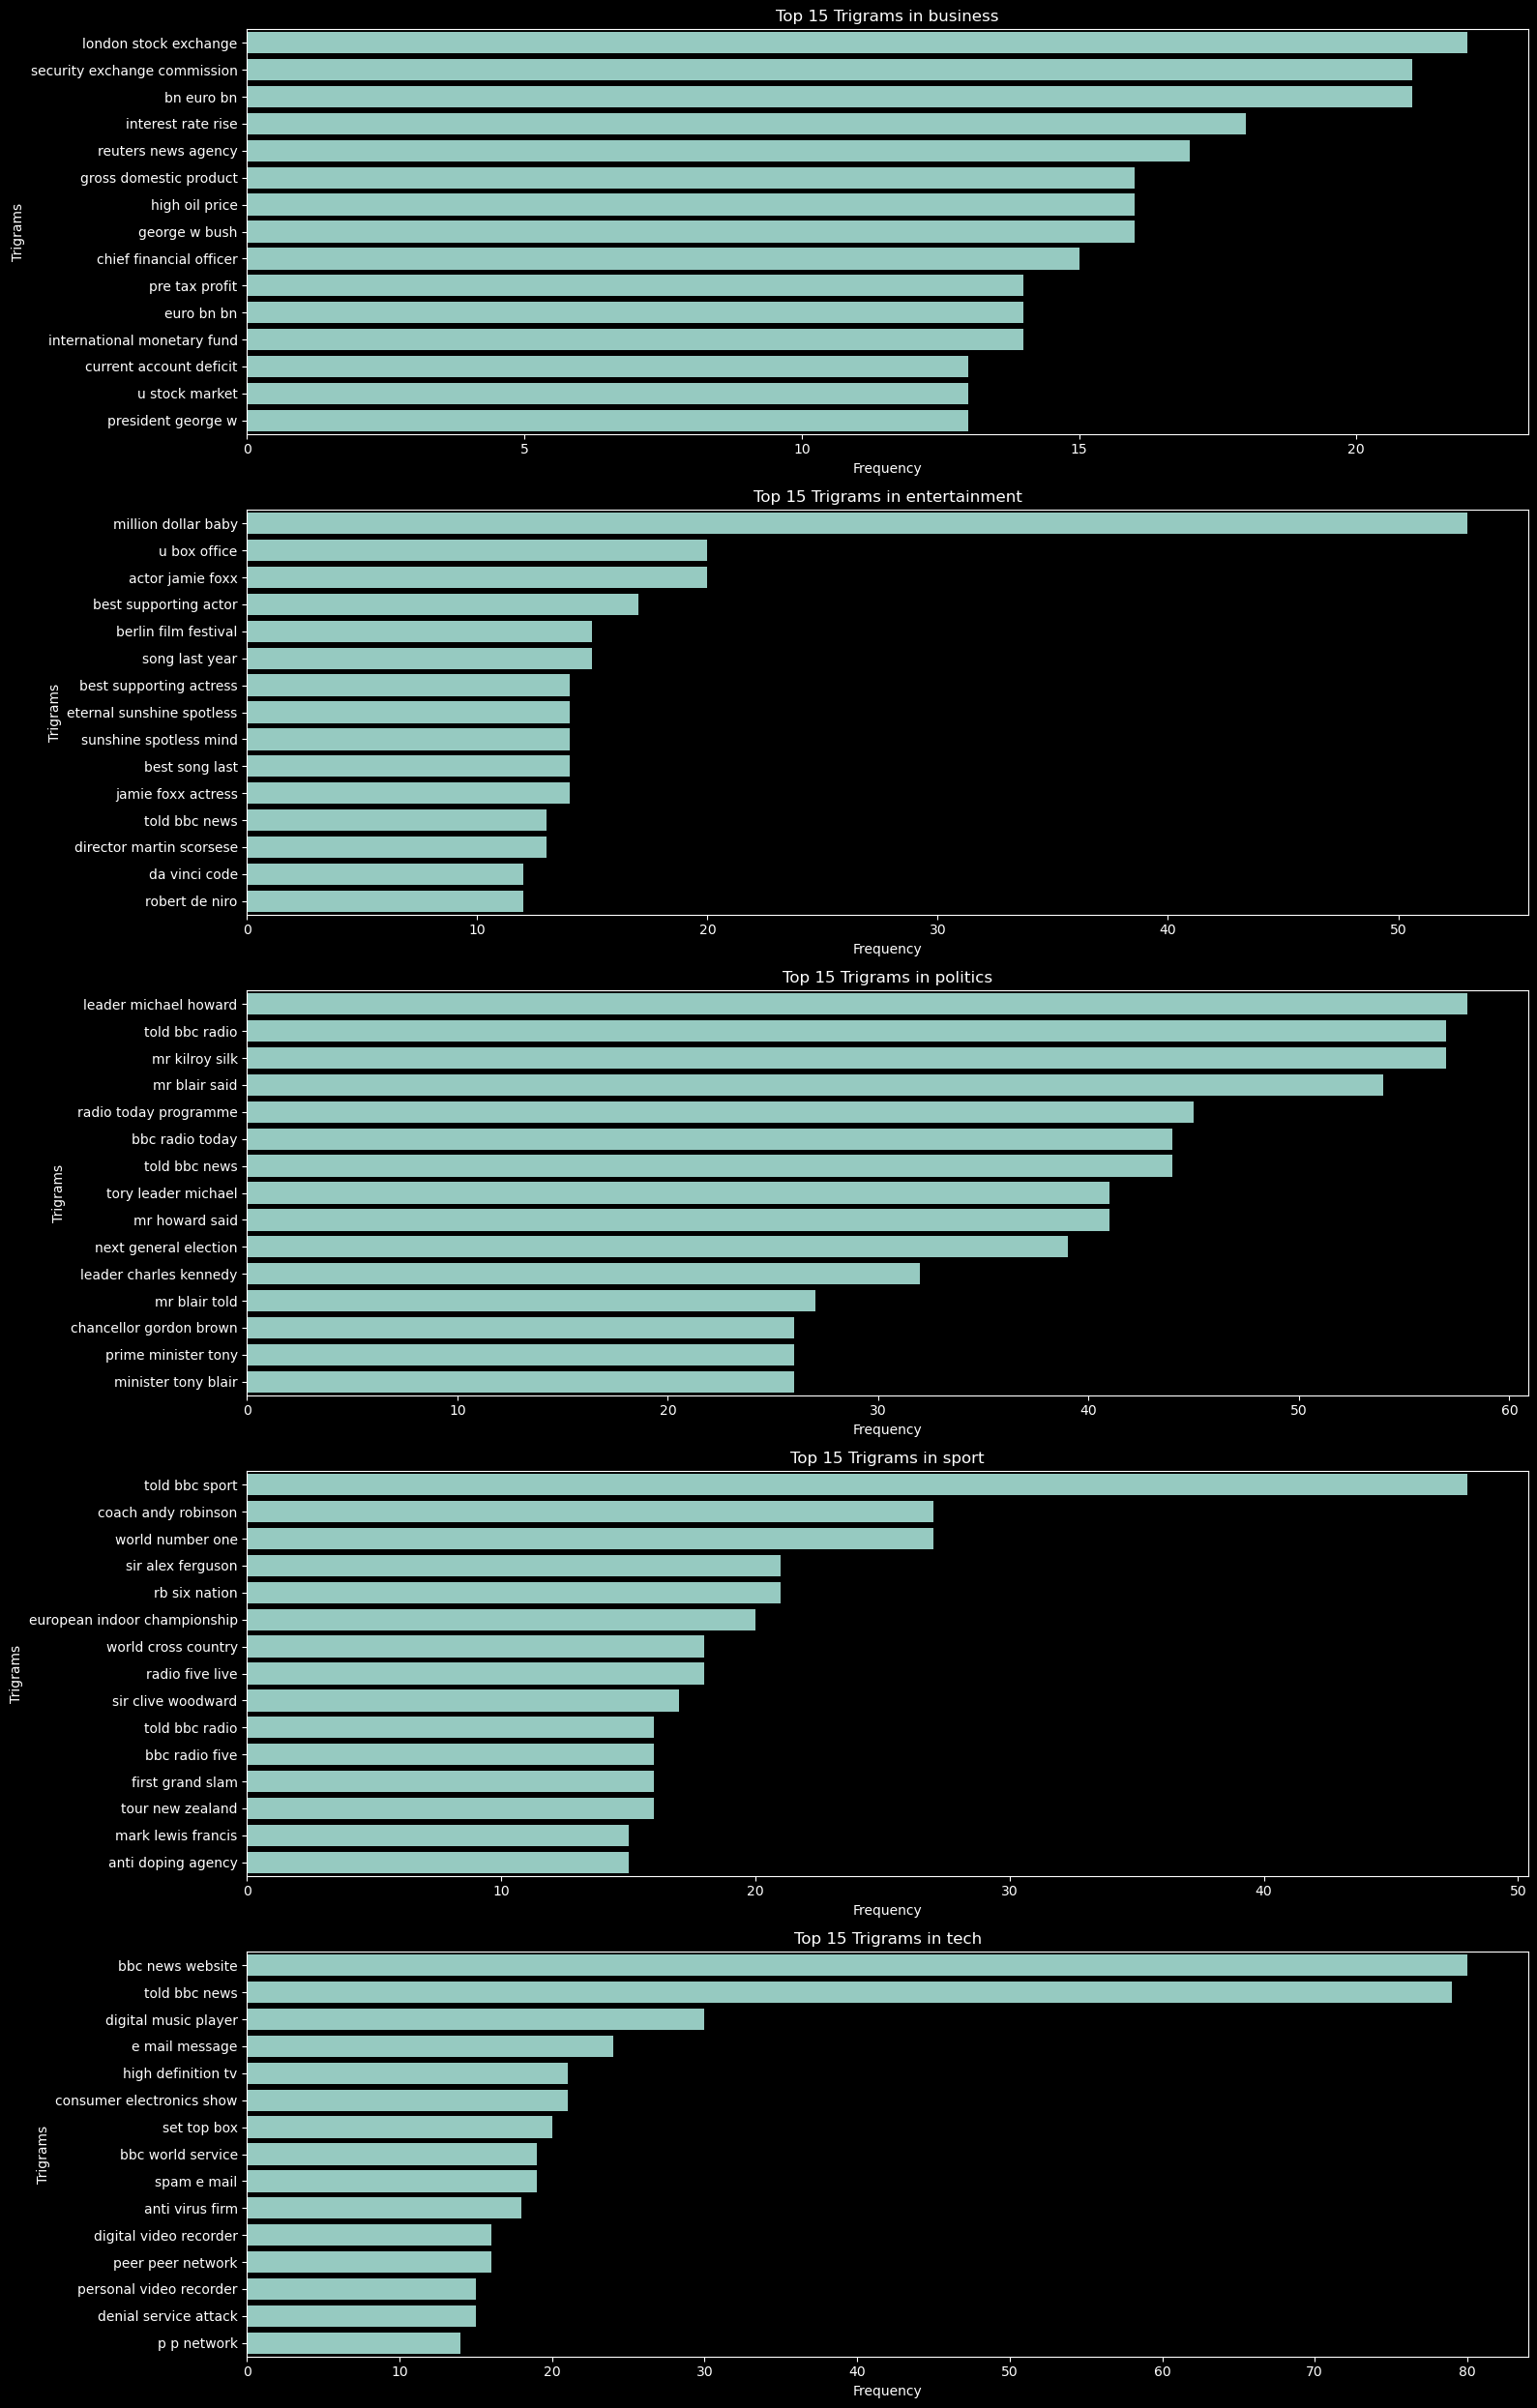

<Figure size 1600x1000 with 0 Axes>

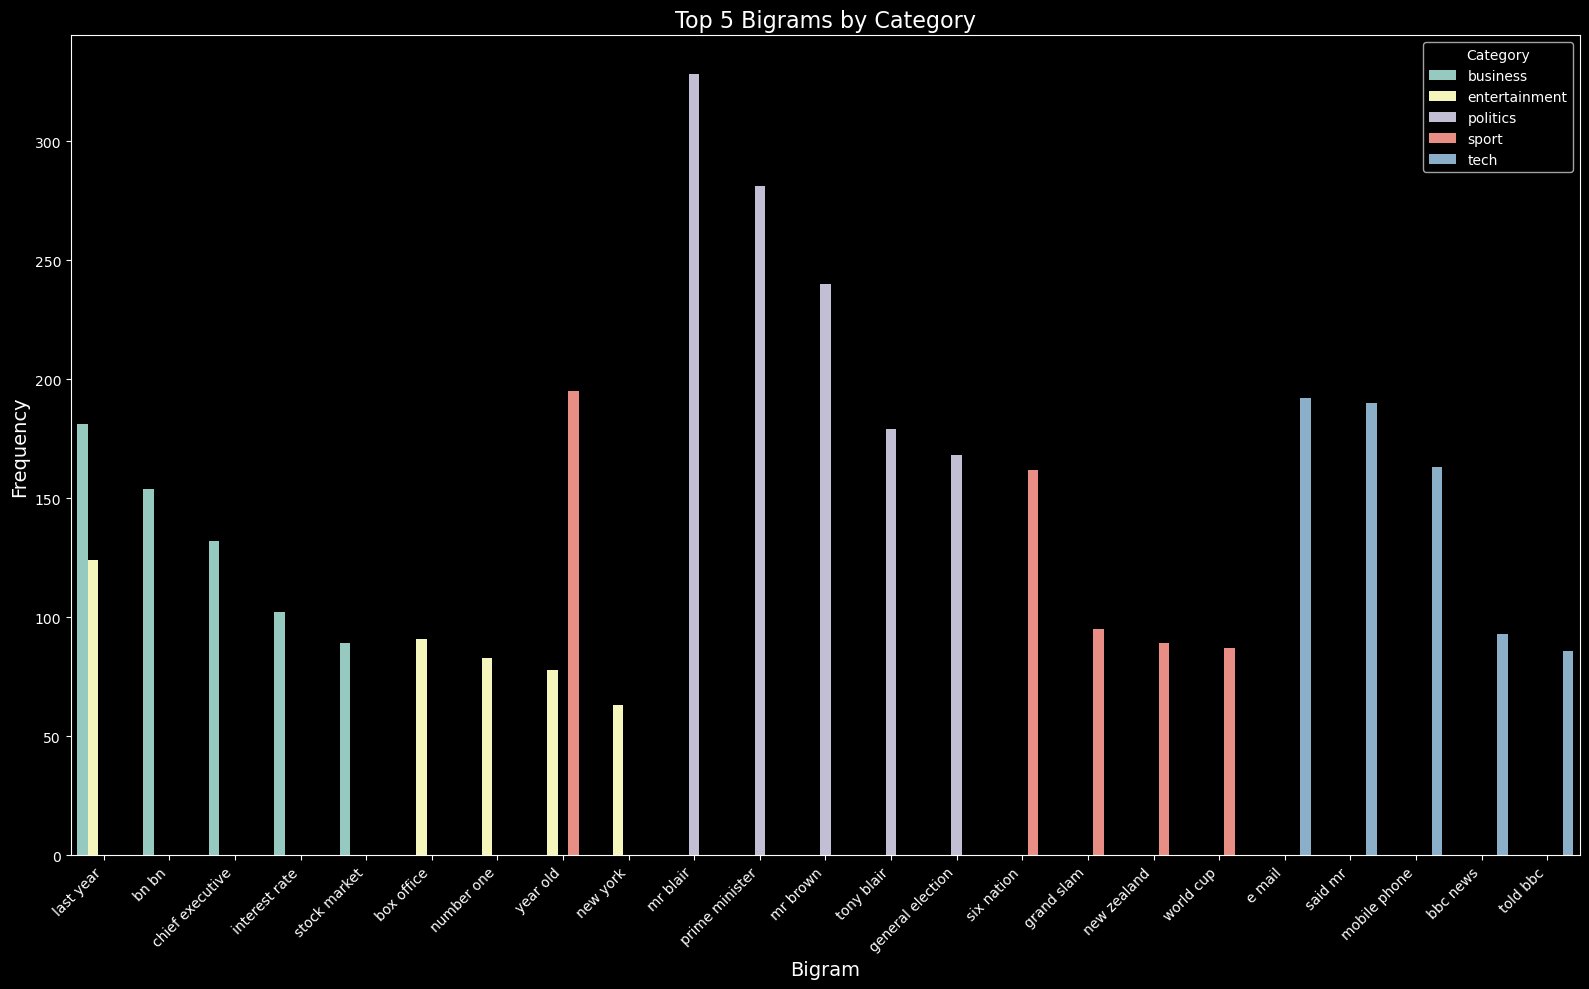

In [8]:
def extract_ngrams(text, n=2):
    tokens = text.split()
    return list(ngrams(tokens, n))

for n in [2, 3]:
    gram_name = 'Bigrams' if n == 2 else 'Trigrams'
    print(f"\n{gram_name} Analysis")

    # subplot for each category
    fig, axes = plt.subplots(len(categories), 1, figsize=(16, 5*len(categories)))

    for i, category in enumerate(categories):

        texts = bbc_df[bbc_df['category'] == category]['normalized_text'].tolist()

        category_ngrams = []
        for text in texts:
            category_ngrams.extend(extract_ngrams(text, n))

        ngram_counts = Counter(category_ngrams)
        top_ngrams = ngram_counts.most_common(15)

        # format n-grams
        top_ngram_labels = [' '.join(gram) for gram, _ in top_ngrams]
        top_ngram_values = [count for _, count in top_ngrams]

        print(f"\nCategory: {category}")
        print(f"  Total {gram_name.lower()}: {len(ngram_counts):,}")
        print(f"  Top 5 {gram_name.lower()}:")
        for j, (gram, count) in enumerate(top_ngrams[:5]):
            print(f"    {j+1}. '{' '.join(gram)}': {count}")

        if len(categories) > 1:
            ax = axes[i]
        else:
            ax = axes

        sns.barplot(x=top_ngram_values, y=top_ngram_labels, ax=ax)
        ax.set_title(f'Top 15 {gram_name} in {category}')
        ax.set_xlabel('Frequency')
        ax.set_ylabel(gram_name)

    plt.tight_layout()
    plt.show()

plt.figure(figsize=(16, 10))

# top 5 bigrams from each category
consolidated_data = []
for category in categories:
    texts = bbc_df[bbc_df['category'] == category]['normalized_text'].tolist()

    category_bigrams = []
    for text in texts:
        category_bigrams.extend(extract_ngrams(text, 2))

    bigram_counts = Counter(category_bigrams)
    top_bigrams = bigram_counts.most_common(5)

    for bigram, count in top_bigrams:
        consolidated_data.append({
            'Category': category,
            'Bigram': ' '.join(bigram),
            'Frequency': count
        })

consolidated_df = pd.DataFrame(consolidated_data)
plt.figure(figsize=(16, 10))
chart = sns.barplot(x='Bigram', y='Frequency', hue='Category', data=consolidated_df)
plt.title('Top 5 Bigrams by Category', fontsize=16)
plt.xlabel('Bigram', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Category')
plt.tight_layout()
plt.show()

## 3. Linguistic analysis

##### 3.1 PARTS-OF-SPEECH DISTRIBUTIONS

<Figure size 1400x800 with 0 Axes>

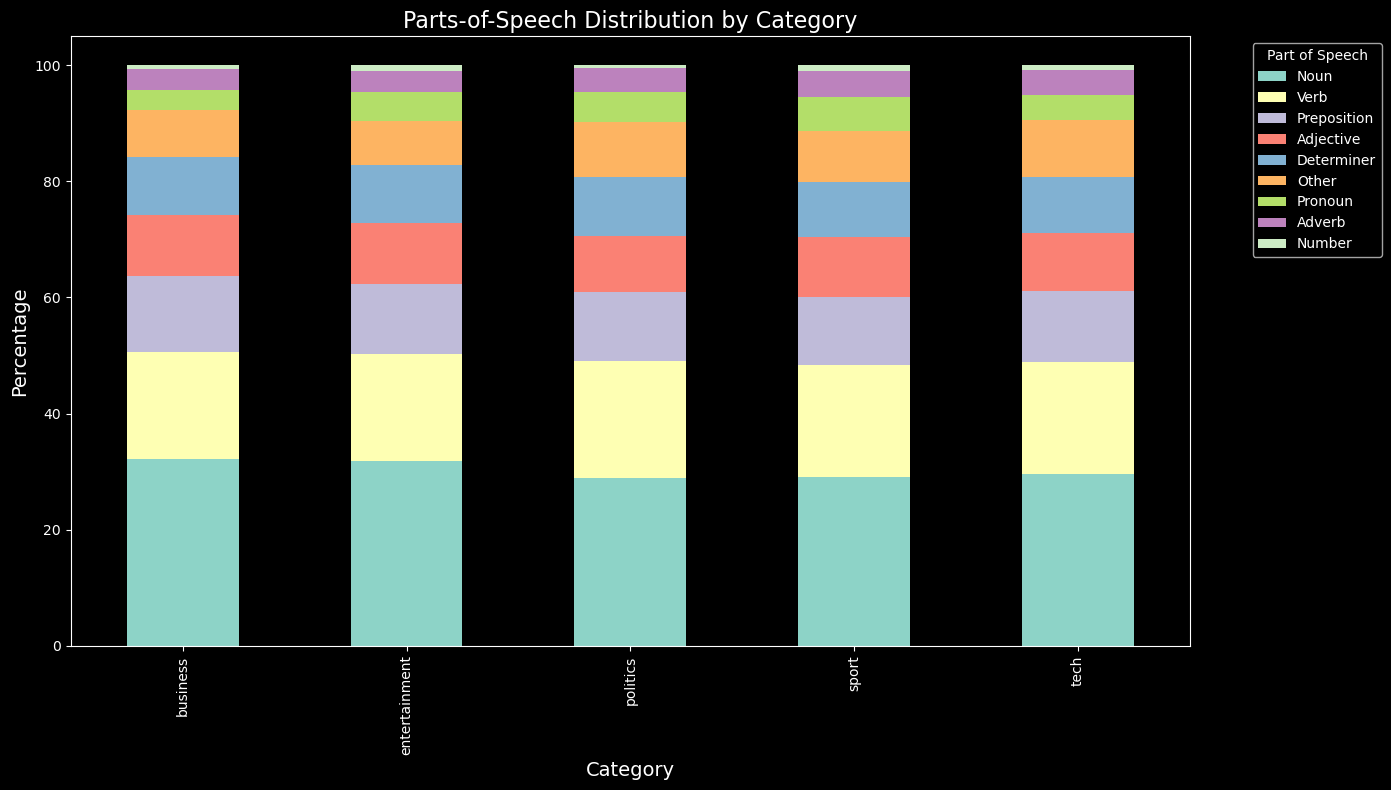

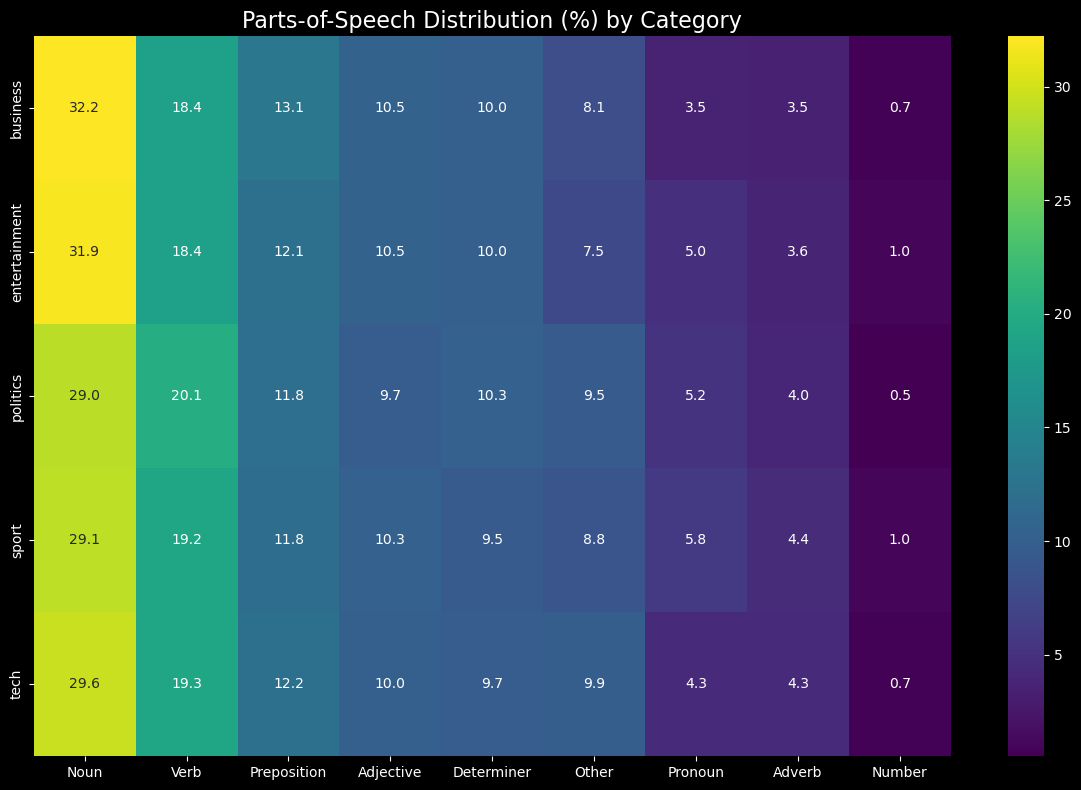

In [9]:
# function to simplify POS tags into main categories
def simplify_pos_tag(tag):
    if tag.startswith('NN'):
        return 'Noun'
    elif tag.startswith('VB'):
        return 'Verb'
    elif tag.startswith('JJ'):
        return 'Adjective'
    elif tag.startswith('RB'):
        return 'Adverb'
    elif tag.startswith('DT') or tag.startswith('PDT'):
        return 'Determiner'
    elif tag.startswith('IN'):
        return 'Preposition'
    elif tag.startswith('PRP') or tag.startswith('WP'):
        return 'Pronoun'
    elif tag.startswith('CD'):
        return 'Number'
    else:
        return 'Other'

pos_distributions = {}

for category in categories:
    texts = bbc_df[bbc_df['category'] == category]['cleaned_text'].tolist()
    pos_counts = Counter()
    total_words = 0

    for text in texts:
        # tokenize and get POS tags
        tokens = word_tokenize(text)
        pos_tags = pos_tag(tokens)

        # count simplified POS tags
        for _, tag in pos_tags:
            simple_tag = simplify_pos_tag(tag)
            pos_counts[simple_tag] += 1
            total_words += 1

    pos_percentages = {tag: (count / total_words) * 100 for tag, count in pos_counts.items()}
    pos_distributions[category] = pos_percentages

pos_df = pd.DataFrame(pos_distributions).T.fillna(0)
pos_df = pos_df.reindex(sorted(pos_df.columns, key=lambda x: pos_df[x].mean(), reverse=True), axis=1)

plt.figure(figsize=(14, 8))
pos_df.plot(kind='bar', stacked=True, figsize=(14, 8))
plt.title('Parts-of-Speech Distribution by Category', fontsize=16)
plt.xlabel('Category', fontsize=14)
plt.ylabel('Percentage', fontsize=14)
plt.legend(title='Part of Speech', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))
sns.heatmap(pos_df, annot=True, cmap='viridis', fmt='.1f')
plt.title('Parts-of-Speech Distribution (%) by Category', fontsize=16)
plt.tight_layout()
plt.show()

## 4. Semantic exploration

##### 4.1 CATEGORY AND DOCUMENT SIMILARITIES


Category semantic similarity (%):
                 business  entertainment    politics       sport        tech
business       100.000000      34.388308   47.292766   33.968162   44.844809
entertainment   34.388308     100.000000   34.331600   37.535296   40.627234
politics        47.292766      34.331600  100.000000   34.112393   40.256214
sport           33.968162      37.535296   34.112393  100.000000   35.969583
tech            44.844809      40.627234   40.256214   35.969583  100.000000


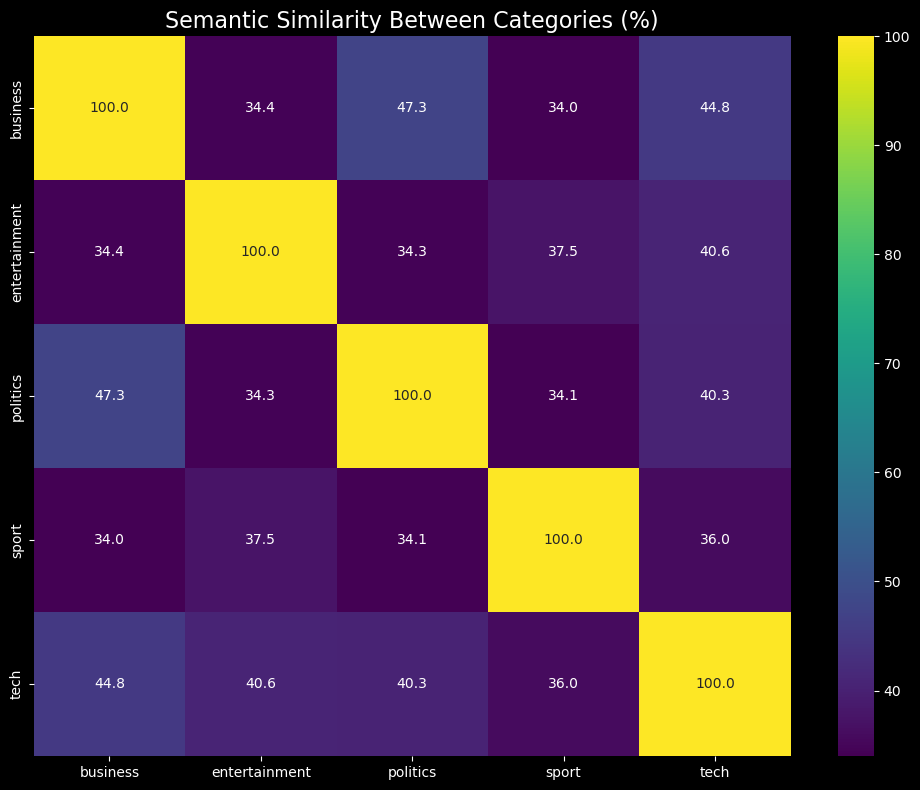

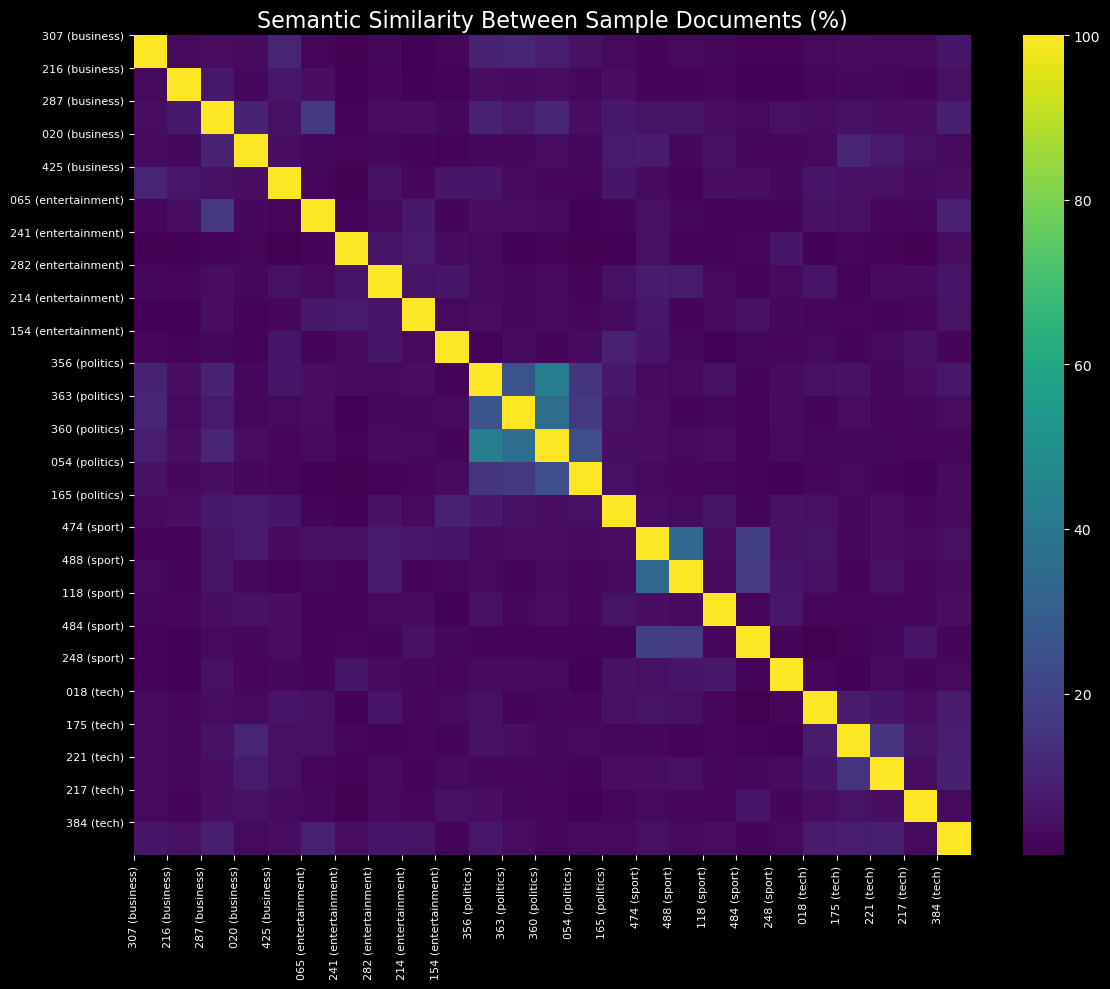

In [17]:
# TF-IDF vectors for all documents
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
tfidf_matrix = tfidf_vectorizer.fit_transform(bbc_df['normalized_text'])

# store document indices by category
category_indices = {category: bbc_df[bbc_df['category'] == category].index.tolist()
                   for category in categories}

# calculate category centroids and inter-category similarity
category_centroids = {}
for category, indices in category_indices.items():
    category_vectors = tfidf_matrix[indices]
    # Convert to numpy array and ensure it's 2D for cosine_similarity
    centroid = np.asarray(category_vectors.mean(axis=0)).flatten().reshape(1, -1)
    category_centroids[category] = centroid

centroid_similarity = pd.DataFrame(0.0, index=categories, columns=categories)
# calc similarity between category centroids
for cat1 in categories:
    for cat2 in categories:
        # Both centroids are already numpy arrays in the correct shape
        sim = float(cosine_similarity(category_centroids[cat1], category_centroids[cat2])[0][0])
        centroid_similarity.loc[cat1, cat2] = sim * 100.0  # Convert to percentage as float

print("\nCategory semantic similarity (%):")
print(centroid_similarity)

# 3. category similarity matrix
plt.figure(figsize=(10, 8))
sns.heatmap(centroid_similarity.astype(float), annot=True, cmap='viridis', fmt='.1f')
plt.title('Semantic Similarity Between Categories (%)', fontsize=16)
plt.tight_layout()
plt.show()

# document-level similarity
# sample random documents from each category for comparison
num_samples = 5
sampled_indices = []
sampled_categories = []

for category in categories:
    indices = category_indices[category]
    sample_size = min(num_samples, len(indices))
    category_samples = np.random.choice(indices, size=sample_size, replace=False)

    sampled_indices.extend(category_samples)
    sampled_categories.extend([category] * sample_size)


sampled_titles = [bbc_df.iloc[i]['file_name'].split('.')[0] for i in sampled_indices]
sample_vectors = tfidf_matrix[sampled_indices]
sample_similarity = cosine_similarity(sample_vectors) * 100

# document similarity matrix
plt.figure(figsize=(12, 10))
ax = sns.heatmap(sample_similarity, annot=False, cmap='viridis')
plt.title('Semantic Similarity Between Sample Documents (%)', fontsize=16)

tick_positions = np.arange(len(sampled_titles))
plt.xticks(tick_positions, [f"{t} ({c})" for t, c in zip(sampled_titles, sampled_categories)],
           rotation=90, fontsize=8)
plt.yticks(tick_positions, [f"{t} ({c})" for t, c in zip(sampled_titles, sampled_categories)],
           rotation=0, fontsize=8)
plt.tight_layout()
plt.show()

##### 4.2 t-SNE VISUALIZATION ON SVD

SVD explained variance ratio (first 10 components): [0.0030933  0.01433193 0.01171111 0.0109405  0.00974415 0.00665161
 0.00590267 0.00568313 0.00535859 0.00526768]
Total variance explained: 29.77%


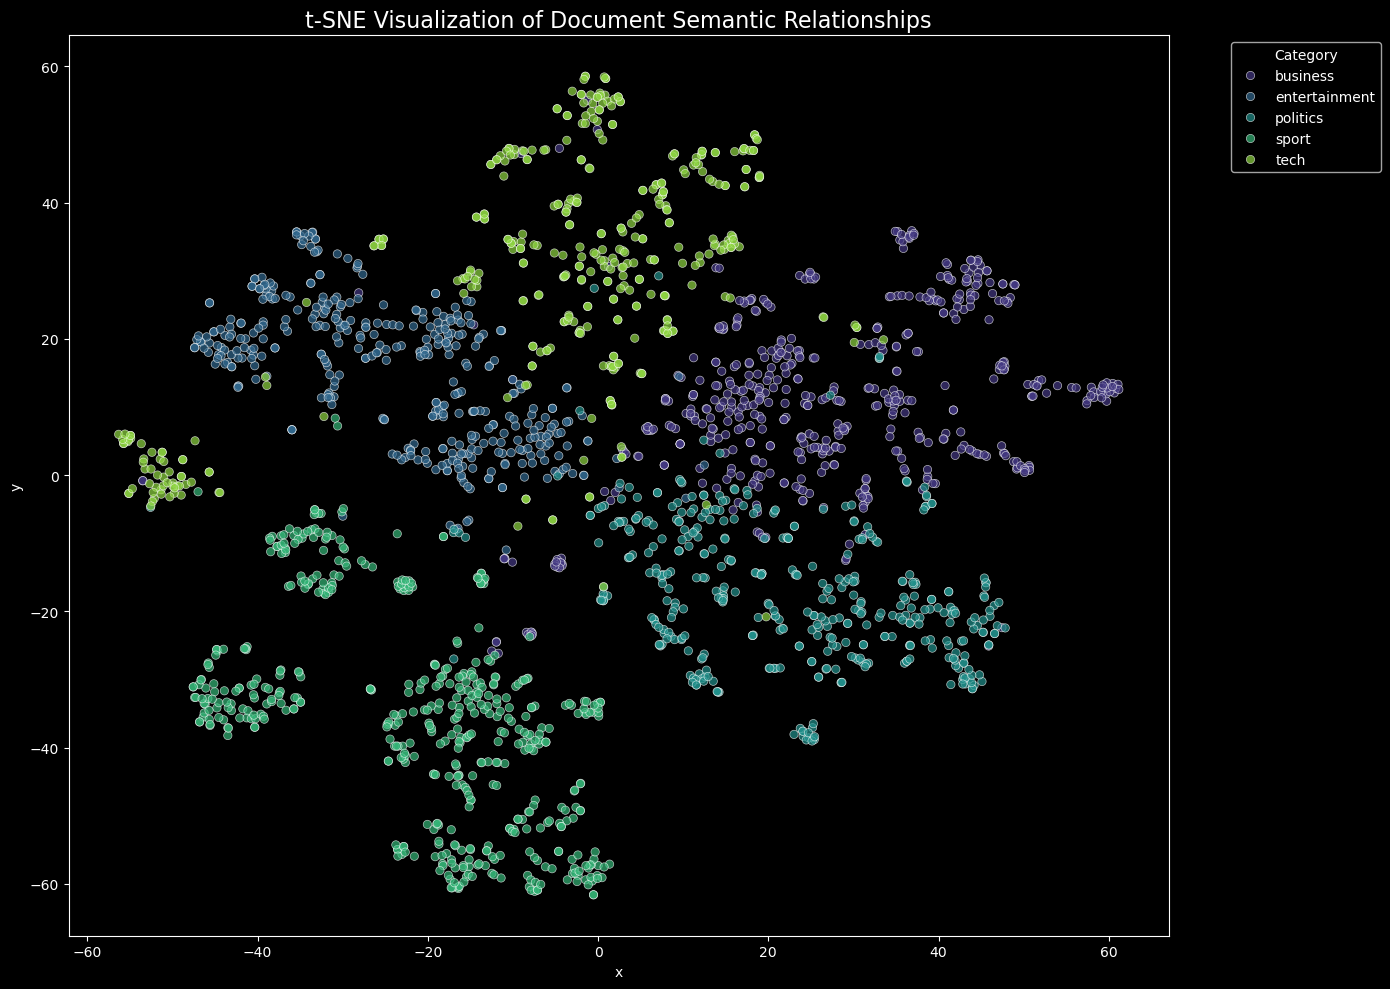

In [11]:
# SVD first to reduce dimensions
n_components = min(100, tfidf_matrix.shape[1] - 1)
svd = TruncatedSVD(n_components=n_components, random_state=42)
svd_result = svd.fit_transform(tfidf_matrix)

print(f"SVD explained variance ratio (first 10 components): {svd.explained_variance_ratio_[:10]}")
print(f"Total variance explained: {sum(svd.explained_variance_ratio_):.2%}")

# t-SNE for visualization
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_result = tsne.fit_transform(svd_result)

tsne_df = pd.DataFrame({
    'x': tsne_result[:, 0],
    'y': tsne_result[:, 1],
    'category': bbc_df['category']
})

plt.figure(figsize=(14, 10))
sns.scatterplot(x='x', y='y', hue='category', data=tsne_df, palette='viridis', alpha=0.7)
plt.title('t-SNE Visualization of Document Semantic Relationships', fontsize=16)
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

##### 4.3 HIERARCHICAL CLUSTERING OF DENDROGRAMS

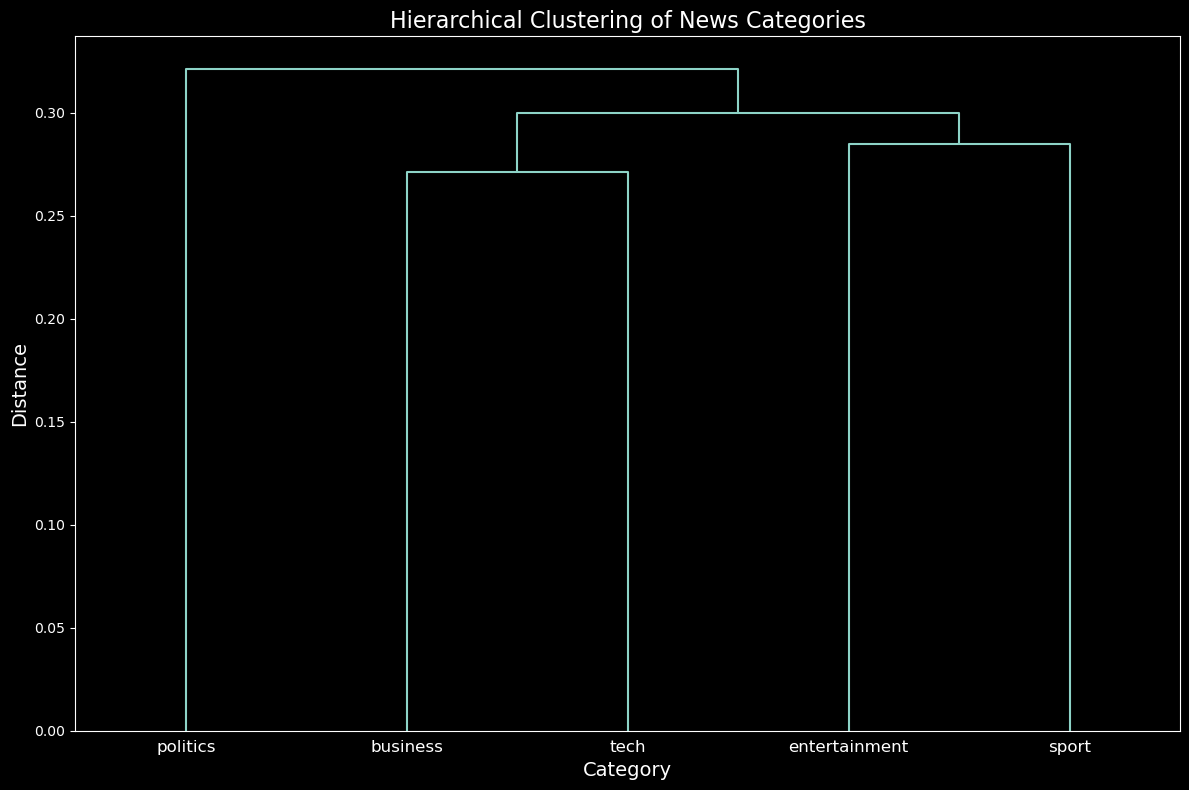

In [12]:
# category-level dendrogram (using centroids)
centroid_array = np.vstack([centroid.flatten() for centroid in category_centroids.values()])
category_names = list(category_centroids.keys())
# calculate linkage matrix for hierarchy
category_linkage = linkage(centroid_array, method='ward')

plt.figure(figsize=(12, 8))
dendrogram(
    category_linkage,
    labels=category_names,
    orientation='top',
    leaf_font_size=12,
    color_threshold=0.7*max(category_linkage[:,2])
)
plt.title('Hierarchical Clustering of News Categories', fontsize=16)
plt.xlabel('Category', fontsize=14)
plt.ylabel('Distance', fontsize=14)
plt.tight_layout()
plt.show()


## 5. Feature correlation

##### 5.1 TOP FEATURES BY CATEGORY

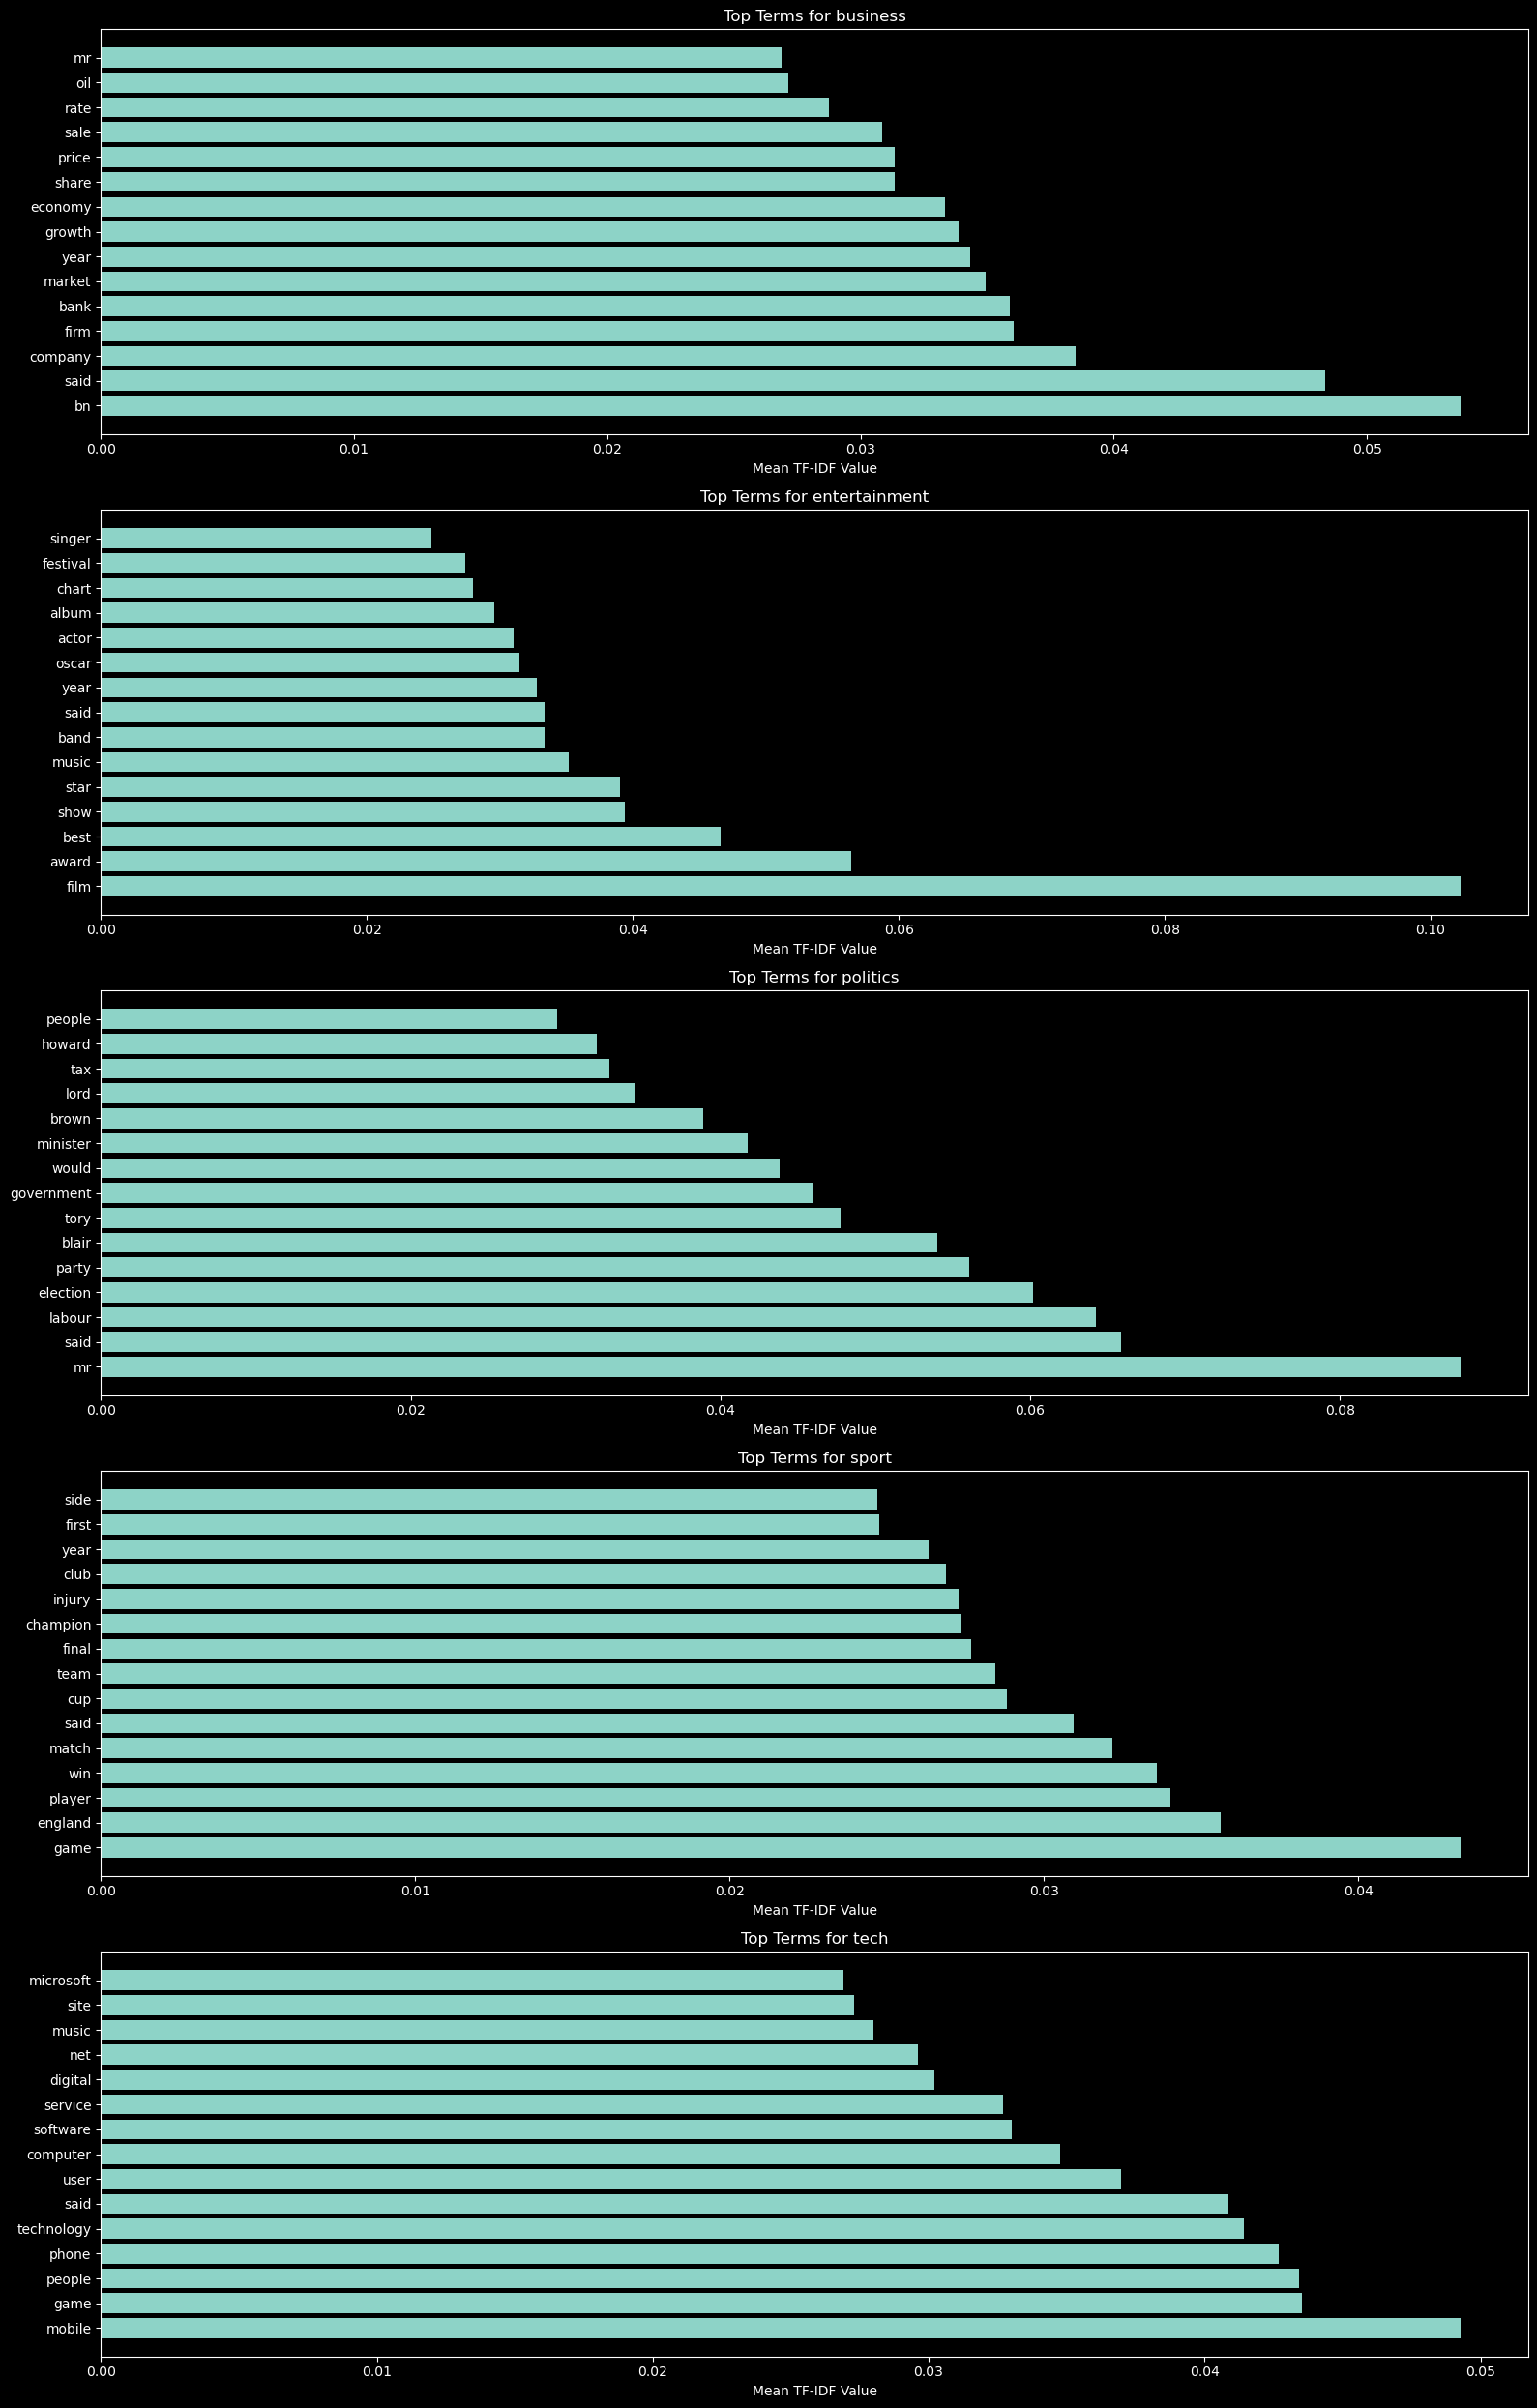

In [ ]:
X = tfidf_vectorizer.fit_transform(bbc_df['normalized_text'])
feature_names = tfidf_vectorizer.get_feature_names_out()
y = bbc_df['category']

# chi-square test to find the most correlated terms with each category
chi2_selector = SelectKBest(chi2, k='all')
chi2_selector.fit(X, y)
chi2_scores = chi2_selector.scores_

# DF with features and their chi-square scores
feature_scores = pd.DataFrame({
    'Feature': feature_names,
    'Chi2_Score': chi2_scores
})

# get the top discriminative terms for each category
def get_top_features_per_category(tfidf_matrix, feature_names, categories, top_n=15):
    category_to_docs = {category: bbc_df[bbc_df['category'] == category].index.tolist()
                       for category in categories}

    results = {}
    for category in categories:
        indices = category_to_docs[category]

        # get average TF-IDF for each term in this category
        category_tfidf_matrix = tfidf_matrix[indices]
        category_tfidf = category_tfidf_matrix.mean(axis=0)

        # convert to 1D array
        category_tfidf_array = np.asarray(category_tfidf).flatten()

        # get indices of top terms for this category
        top_indices = category_tfidf_array.argsort()[-top_n:][::-1]

        # get the feature names and their average TF-IDF values
        top_features = [(feature_names[i], category_tfidf_array[i]) for i in top_indices]
        results[category] = top_features

    return results

top_features = get_top_features_per_category(X, feature_names, categories)

plt.figure(figsize=(16, 5 * len(categories)))
for i, (category, features) in enumerate(top_features.items()):
    plt.subplot(len(categories), 1, i+1)

    terms = [f[0] for f in features]
    values = [f[1] for f in features]

    plt.barh(range(len(terms)), values, align='center')
    plt.yticks(range(len(terms)), terms)
    plt.title(f'Top Terms for {category}')
    plt.xlabel('Mean TF-IDF Value')

plt.tight_layout()
plt.show()


##### 5.2 APPLY PCA AND VISUALIZE PC1 TO 3

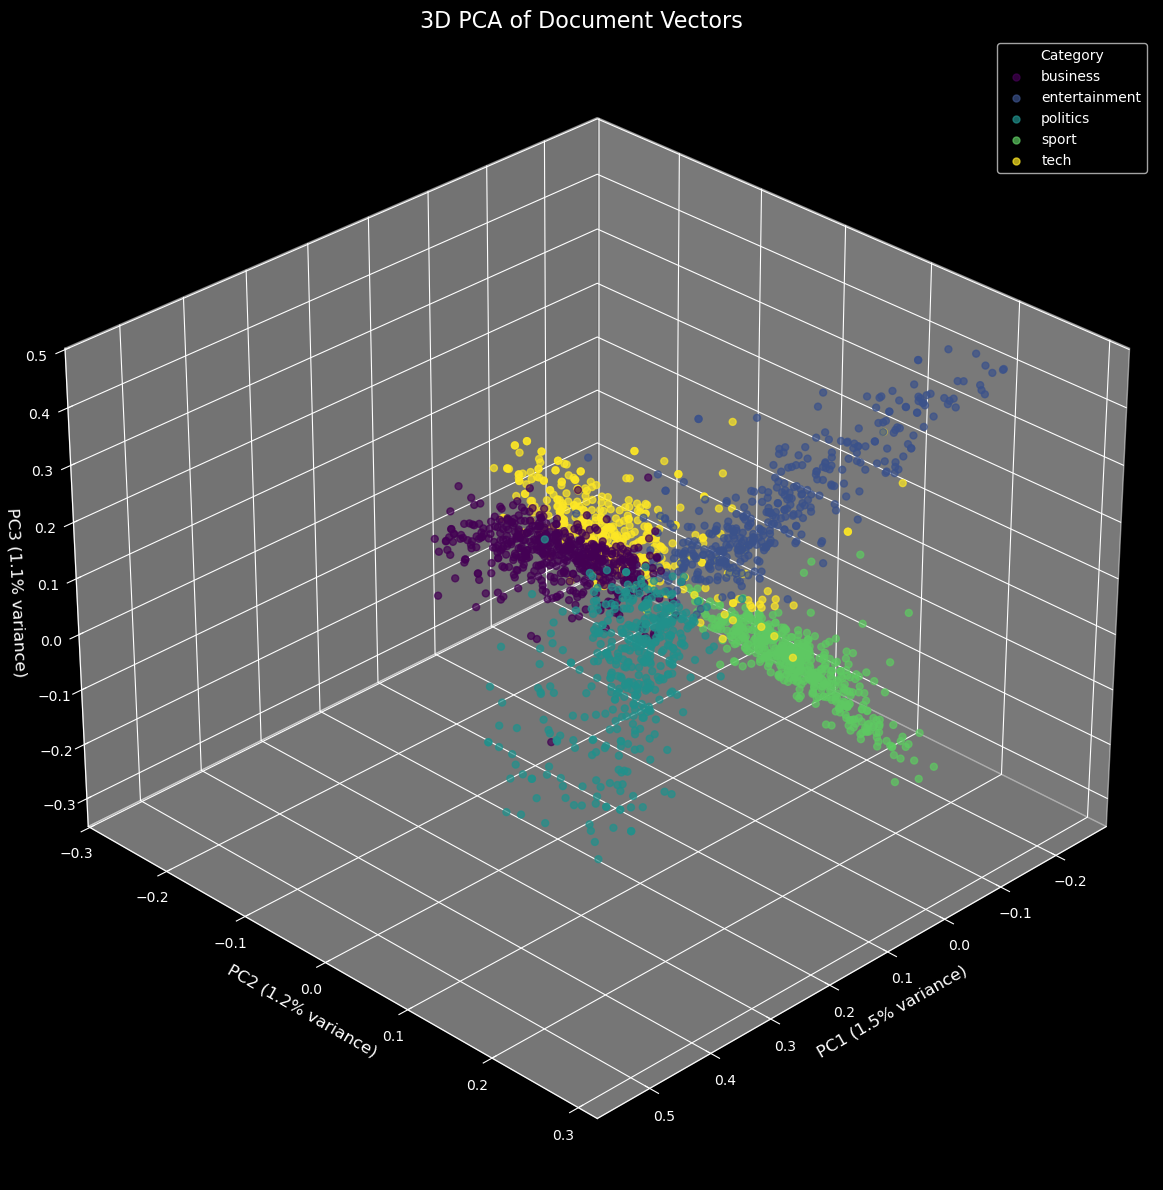

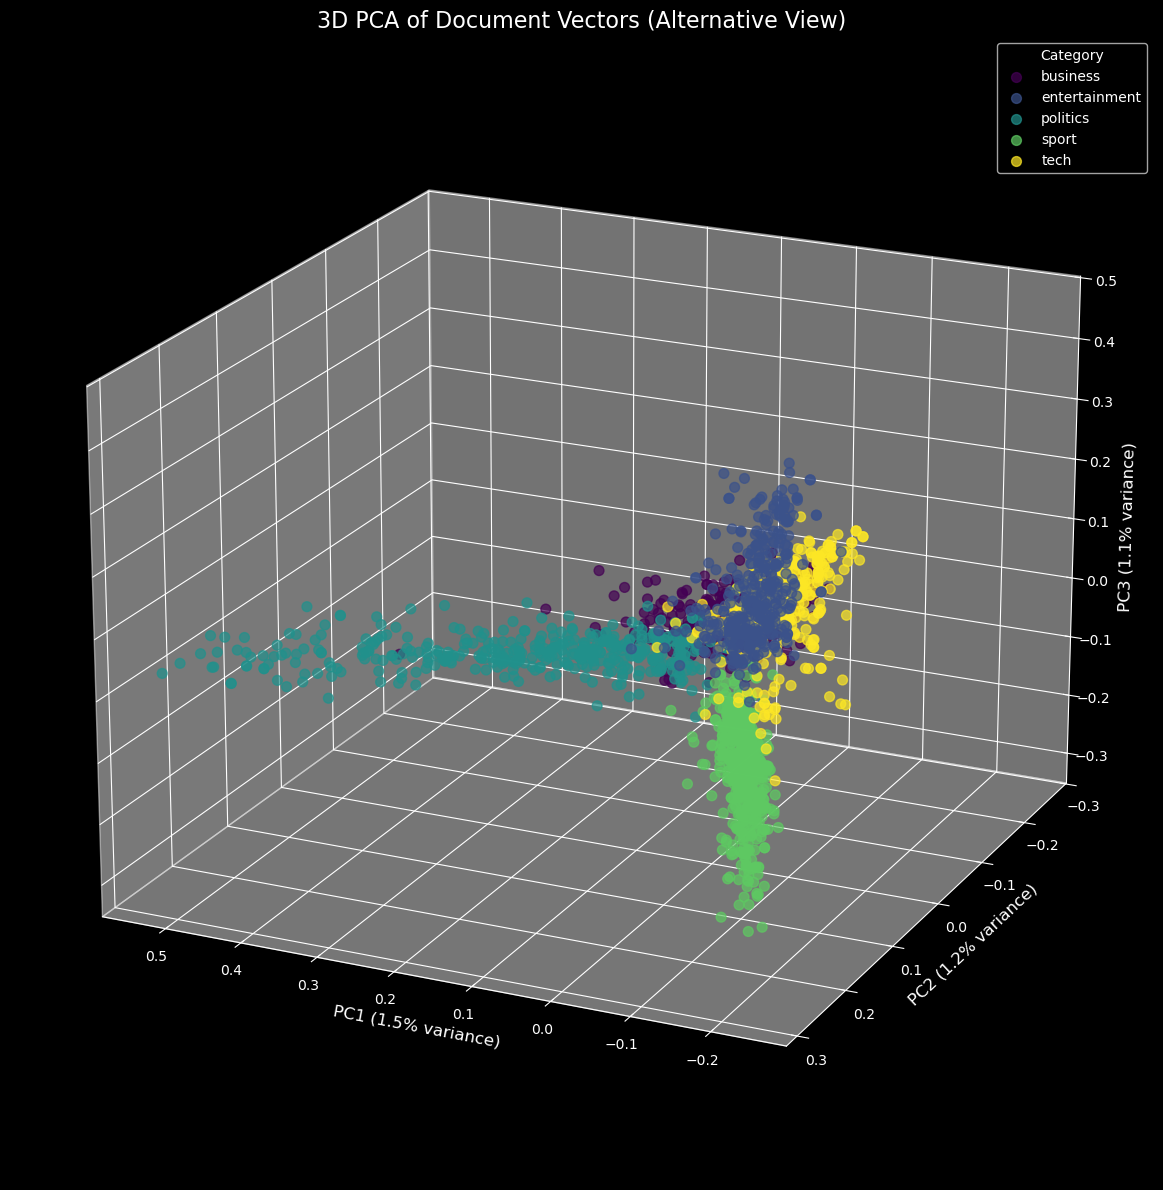

In [ ]:
X_dense = X.toarray()
pca = PCA(n_components=3)
pca_result = pca.fit_transform(X_dense)

pca_df = pd.DataFrame({
    'PC1': pca_result[:, 0],
    'PC2': pca_result[:, 1],
    'PC3': pca_result[:, 2],
    'category': y
})


# 3D PCA
fig = plt.figure(figsize=(14, 12))
ax = fig.add_subplot(111, projection='3d')

# color map for categories
categories_list = categories.tolist()
colors = plt.cm.viridis(np.linspace(0, 1, len(categories_list)))
for i, category in enumerate(categories_list):
    category_data = pca_df[pca_df['category'] == category]
    ax.scatter(
        category_data['PC1'],
        category_data['PC2'],
        category_data['PC3'],
        label=category,
        color=colors[i],
        alpha=0.7,
        s=25  # point size
    )

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=12)
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=12)
ax.set_zlabel(f'PC3 ({pca.explained_variance_ratio_[2]:.1%} variance)', fontsize=12)
ax.set_title('3D PCA of Document Vectors', fontsize=16)
ax.legend(title='Category')
ax.view_init(elev=30, azim=45)
plt.tight_layout()
plt.show()

# another 3D view from a different angle
fig = plt.figure(figsize=(14, 12))
ax = fig.add_subplot(111, projection='3d')

for i, category in enumerate(categories_list):
    category_data = pca_df[pca_df['category'] == category]
    ax.scatter(
        category_data['PC1'],
        category_data['PC2'],
        category_data['PC3'],
        label=category,
        color=colors[i],
        alpha=0.7,
        s=50
    )

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=12)
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=12)
ax.set_zlabel(f'PC3 ({pca.explained_variance_ratio_[2]:.1%} variance)', fontsize=12)
ax.set_title('3D PCA of Document Vectors (Alternative View)', fontsize=16)
ax.legend(title='Category')
ax.view_init(elev=20, azim=115)
plt.tight_layout()
plt.show()

# Conclusion

#### 1. Category Distinctiveness:
- The relatively low vocabulary overlap between categories (28-35%) suggests that a bag-of-words or TF-IDF approach will yield high classification accuracy.
- Sport category, having the lowest average overlap with other categories, will be the most easily distinguishable in classification tasks.

#### 2. Named Entity Importance:
- Named entities (people, organizations) will be strong discriminative features for classification, particularly in politics ("blair"), sports ("roddick", "mourinho"), and business ("yukos", "gazprom").

#### 3. Common Reporting Words:
- We might need to adjust the preprocessing (manually remove words like "said" or use other stopwords) if the model results are not satisfactory.

#### 4. Topic-Specific Terminology:
Domain-specific vocabulary will be the strongest predictors for each category:
- Financial terms for business
- Arts and media terms for entertainment
- Political institutions and parties for politics
- Athletes and competitions for sport
- Products and technical terms for tech

#### 5. Reporting Style Differences:
- Politics and business articles will show similar formal language structures, explaining their higher vocabulary overlap (35.8%).
- Entertainment articles will demonstrate the most diverse vocabulary based on unique word count.

#### 6. Bigram Pattern Relevance:
- Political articles will be most accurately identified by named entity bigrams (e.g., "mr blair", "prime minister"), while sports articles will be distinguished by event-specific terminology ("six nation", "grand slam").

#### 7. POS Distributions:
- Each type of article seems to represent the same normal POS distribution just like any other text.

#### 8. Document Clustering Patterns:
- Based on the t-SNE and PCA visualizations, sport articles will achieve the highest classification accuracy due to their distinct semantic clustering.
- Politics and business articles will be most frequently misclassified with each other given their higher semantic similarity (47.3%).

#### 9. Category Boundary Characteristics:
- The significant cluster overlap in dimensionality reduction visualizations suggests that approximately 15-20% of documents will fall in "boundary regions" between categories.
- These boundary-case documents will likely contain cross-domain topics (e.g., business-politics, technology-business).